In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/u/0/uc?id=1f9gxP3v6ystFbZgf2blIzcpUNk4BFV4C&export=download"
output = "data_gaussian_1024.zip"
gdown.download(url, output)
!unzip data_gaussian_1024.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1f9gxP3v6ystFbZgf2blIzcpUNk4BFV4C&export=download
From (redirected): https://drive.google.com/uc?id=1f9gxP3v6ystFbZgf2blIzcpUNk4BFV4C&export=download&confirm=t&uuid=1937710f-4f09-4517-91ba-47fb93c53781
To: /content/data_gaussian_1024.zip
100%|██████████| 158M/158M [00:02<00:00, 77.1MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_1024/jammed_channel/images/2_104.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_105.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_106.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_107.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_108.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_109.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_110.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_111.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_112.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_113.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_114.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_115.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_116.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_117.png  
  inflating: data_gaussian

In [4]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_1024")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_1024/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:34<01:43, 34.41s/it]

jammed_channel



 50%|█████     | 2/4 [00:36<00:31, 15.67s/it]

test



 75%|███████▌  | 3/4 [00:41<00:10, 10.39s/it]

clean_validation



100%|██████████| 4/4 [00:44<00:00, 11.23s/it]


In [5]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [6]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

In [9]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 20s 49ms/step - loss: 0.0365 - val_loss: 0.0354
Epoch 2/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 3/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0310 - val_loss: 0.0282
Epoch 4/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0278 - val_loss: 0.0279
Epoch 5/20
125/125 [==============================] - 7s 52ms/step - loss: 0.0276 - val_loss: 0.0278
Epoch 6/20
125/125 [==============================] - 6s 47ms/step - loss: 0.0276 - val_loss: 0.0277
Epoch 7/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 8/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 9/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0275 - val_loss: 0.0277
Epoch 10/20
125/125 [==============================] - 6s 47ms/step - loss: 0.0275 - val_l

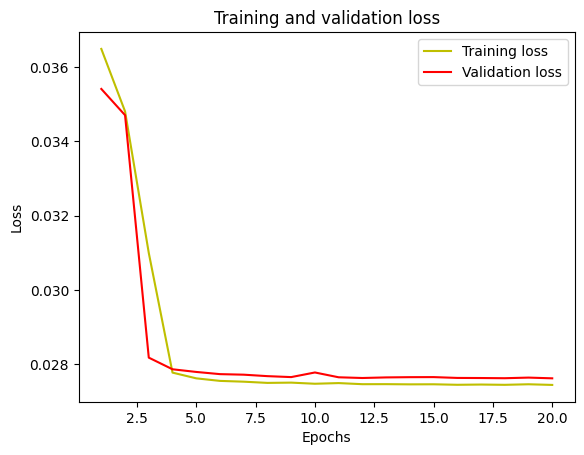

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 0s 20ms/step


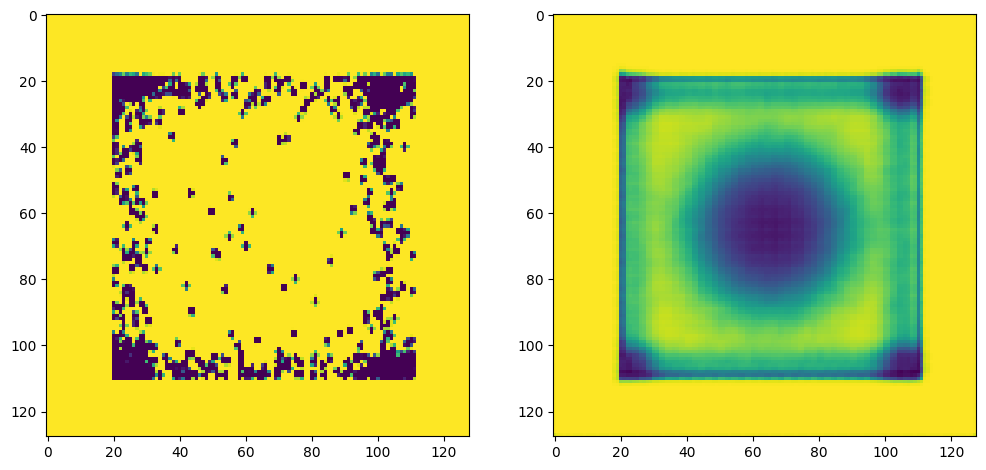

In [12]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [13]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 46ms/step - loss: 0.0293
Validation error 0.027622124180197716
Anomaly error 0.029339665547013283
The reconstruction error of the jammed channel is  1.0621799162009007  more than the clean channel


In [14]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [15]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 130ms/step - loss: 0.0265


  0%|          | 1/600 [00:00<02:22,  4.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


  0%|          | 3/600 [00:00<01:09,  8.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0258


  1%|          | 5/600 [00:00<00:52, 11.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


  1%|          | 7/600 [00:00<00:48, 12.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


  2%|▏         | 9/600 [00:00<00:46, 12.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


  2%|▏         | 11/600 [00:00<00:45, 12.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0250


  2%|▏         | 13/600 [00:01<00:42, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


  2%|▎         | 15/600 [00:01<00:41, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0237


  3%|▎         | 17/600 [00:01<00:41, 13.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0289


  3%|▎         | 19/600 [00:01<00:41, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


  4%|▎         | 21/600 [00:01<00:39, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


  4%|▍         | 23/600 [00:01<00:39, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


  4%|▍         | 25/600 [00:01<00:38, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


  4%|▍         | 27/600 [00:02<00:37, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0242


  5%|▍         | 29/600 [00:02<00:36, 15.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0243


  5%|▌         | 31/600 [00:02<00:37, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


  6%|▌         | 33/600 [00:02<00:36, 15.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


  6%|▌         | 35/600 [00:02<00:37, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


  6%|▌         | 37/600 [00:02<00:36, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0310


  6%|▋         | 39/600 [00:02<00:37, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


  7%|▋         | 41/600 [00:02<00:37, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


  7%|▋         | 43/600 [00:03<00:36, 15.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0257


  8%|▊         | 45/600 [00:03<00:35, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0249


  8%|▊         | 47/600 [00:03<00:37, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


  8%|▊         | 49/600 [00:03<00:37, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


  8%|▊         | 51/600 [00:03<00:36, 14.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


  9%|▉         | 53/600 [00:03<00:35, 15.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0255


  9%|▉         | 55/600 [00:03<00:35, 15.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0241


 10%|▉         | 57/600 [00:03<00:36, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 10%|▉         | 59/600 [00:04<00:35, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 10%|█         | 61/600 [00:04<00:35, 15.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0281


 10%|█         | 63/600 [00:04<00:36, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0236


 11%|█         | 65/600 [00:04<00:36, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0252


 11%|█         | 67/600 [00:04<00:35, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 12%|█▏        | 69/600 [00:04<00:36, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 12%|█▏        | 71/600 [00:04<00:34, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0249


 12%|█▏        | 73/600 [00:05<00:33, 15.52it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0276


 12%|█▎        | 75/600 [00:05<00:38, 13.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 13%|█▎        | 77/600 [00:05<00:37, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0270


 13%|█▎        | 79/600 [00:05<00:37, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


 14%|█▎        | 81/600 [00:05<00:36, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 14%|█▍        | 83/600 [00:05<00:36, 14.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 14%|█▍        | 85/600 [00:05<00:34, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 14%|█▍        | 87/600 [00:06<00:34, 14.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0274


 15%|█▍        | 89/600 [00:06<00:33, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 15%|█▌        | 91/600 [00:06<00:32, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 16%|█▌        | 93/600 [00:06<00:33, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0245


 16%|█▌        | 95/600 [00:06<00:34, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0235


 16%|█▌        | 97/600 [00:06<00:33, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


 16%|█▋        | 99/600 [00:06<00:33, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 17%|█▋        | 101/600 [00:06<00:32, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0304


 17%|█▋        | 103/600 [00:07<00:31, 15.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 18%|█▊        | 105/600 [00:07<00:31, 15.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 18%|█▊        | 107/600 [00:07<00:31, 15.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0286


 18%|█▊        | 109/600 [00:07<00:32, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0268


 18%|█▊        | 111/600 [00:07<00:31, 15.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0296


 19%|█▉        | 113/600 [00:07<00:31, 15.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 19%|█▉        | 115/600 [00:07<00:33, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 20%|█▉        | 117/600 [00:08<00:31, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


 20%|█▉        | 119/600 [00:08<00:31, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


 20%|██        | 121/600 [00:08<00:31, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 20%|██        | 123/600 [00:08<00:32, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 21%|██        | 125/600 [00:08<00:31, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


 21%|██        | 127/600 [00:08<00:31, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 22%|██▏       | 129/600 [00:08<00:31, 14.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 22%|██▏       | 131/600 [00:08<00:30, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


 22%|██▏       | 133/600 [00:09<00:30, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0271


 22%|██▎       | 135/600 [00:09<00:30, 15.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 23%|██▎       | 137/600 [00:09<00:30, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 23%|██▎       | 139/600 [00:09<00:30, 15.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0280


 24%|██▎       | 141/600 [00:09<00:30, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0255


 24%|██▍       | 143/600 [00:09<00:30, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0259


 24%|██▍       | 145/600 [00:09<00:29, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 24%|██▍       | 147/600 [00:09<00:29, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 25%|██▍       | 149/600 [00:10<00:28, 15.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0259


 25%|██▌       | 151/600 [00:10<00:31, 14.09it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0286


 26%|██▌       | 153/600 [00:10<00:34, 13.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0283


 26%|██▌       | 155/600 [00:10<00:35, 12.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0256


 26%|██▌       | 157/600 [00:10<00:40, 10.96it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0294


 26%|██▋       | 159/600 [00:11<00:40, 10.83it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0300


 27%|██▋       | 161/600 [00:11<00:40, 10.87it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0301


 27%|██▋       | 163/600 [00:11<00:40, 10.92it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0270


 28%|██▊       | 165/600 [00:11<00:40, 10.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0276


 28%|██▊       | 167/600 [00:11<00:40, 10.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0299


 28%|██▊       | 169/600 [00:12<00:40, 10.60it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0226


 28%|██▊       | 171/600 [00:12<00:40, 10.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0271


 29%|██▉       | 173/600 [00:12<00:40, 10.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0290


 29%|██▉       | 175/600 [00:12<00:38, 11.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 30%|██▉       | 177/600 [00:12<00:34, 12.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0231


 30%|██▉       | 179/600 [00:12<00:32, 12.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0256


 30%|███       | 181/600 [00:12<00:31, 13.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 30%|███       | 183/600 [00:13<00:29, 14.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


 31%|███       | 185/600 [00:13<00:29, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 31%|███       | 187/600 [00:13<00:28, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0270


 32%|███▏      | 189/600 [00:13<00:29, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0298


 32%|███▏      | 191/600 [00:13<00:29, 13.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 32%|███▏      | 193/600 [00:13<00:28, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 32%|███▎      | 195/600 [00:13<00:28, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0250


 33%|███▎      | 197/600 [00:14<00:27, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


 33%|███▎      | 199/600 [00:14<00:27, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0301


 34%|███▎      | 201/600 [00:14<00:26, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 34%|███▍      | 203/600 [00:14<00:26, 14.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


 34%|███▍      | 205/600 [00:14<00:27, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 34%|███▍      | 207/600 [00:14<00:26, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 35%|███▍      | 209/600 [00:14<00:26, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 35%|███▌      | 211/600 [00:14<00:26, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 36%|███▌      | 213/600 [00:15<00:26, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0237


 36%|███▌      | 215/600 [00:15<00:26, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 36%|███▌      | 217/600 [00:15<00:25, 14.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 36%|███▋      | 219/600 [00:15<00:26, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 37%|███▋      | 221/600 [00:15<00:27, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 37%|███▋      | 223/600 [00:15<00:26, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


 38%|███▊      | 225/600 [00:15<00:26, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 38%|███▊      | 227/600 [00:16<00:25, 14.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 38%|███▊      | 229/600 [00:16<00:25, 14.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0275


 38%|███▊      | 231/600 [00:16<00:25, 14.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0262


 39%|███▉      | 233/600 [00:16<00:24, 14.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 39%|███▉      | 235/600 [00:16<00:25, 14.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0236


 40%|███▉      | 237/600 [00:16<00:25, 14.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 40%|███▉      | 239/600 [00:16<00:25, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 40%|████      | 241/600 [00:17<00:25, 14.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0259


 40%|████      | 243/600 [00:17<00:24, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0257


 41%|████      | 245/600 [00:17<00:24, 14.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0265


 41%|████      | 247/600 [00:17<00:23, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 42%|████▏     | 249/600 [00:17<00:23, 15.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 42%|████▏     | 251/600 [00:17<00:23, 15.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0314


 42%|████▏     | 253/600 [00:17<00:23, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 42%|████▎     | 255/600 [00:18<00:23, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0262


 43%|████▎     | 257/600 [00:18<00:22, 14.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0229


 43%|████▎     | 259/600 [00:18<00:22, 14.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0304


 44%|████▎     | 261/600 [00:18<00:22, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0237


 44%|████▍     | 263/600 [00:18<00:22, 15.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0233


 44%|████▍     | 265/600 [00:18<00:23, 14.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 44%|████▍     | 267/600 [00:18<00:22, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 45%|████▍     | 269/600 [00:18<00:23, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 45%|████▌     | 271/600 [00:19<00:23, 14.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 46%|████▌     | 273/600 [00:19<00:23, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0509


 46%|████▌     | 275/600 [00:19<00:22, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 46%|████▌     | 277/600 [00:19<00:22, 14.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 46%|████▋     | 279/600 [00:19<00:22, 14.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0251


 47%|████▋     | 281/600 [00:19<00:22, 14.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0243


 47%|████▋     | 283/600 [00:19<00:21, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 48%|████▊     | 285/600 [00:20<00:21, 14.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 48%|████▊     | 287/600 [00:20<00:21, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0230


 48%|████▊     | 289/600 [00:20<00:21, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


 48%|████▊     | 291/600 [00:20<00:21, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 49%|████▉     | 293/600 [00:20<00:21, 14.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0257


 49%|████▉     | 295/600 [00:20<00:21, 14.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 50%|████▉     | 297/600 [00:20<00:21, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0244


 50%|████▉     | 299/600 [00:21<00:21, 13.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0302


 50%|█████     | 301/600 [00:21<00:21, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0237


 50%|█████     | 303/600 [00:21<00:20, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 51%|█████     | 305/600 [00:21<00:20, 14.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0257


 51%|█████     | 307/600 [00:21<00:20, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 52%|█████▏    | 309/600 [00:21<00:20, 14.43it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


 52%|█████▏    | 311/600 [00:21<00:20, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 52%|█████▏    | 313/600 [00:22<00:19, 14.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0234


 52%|█████▎    | 315/600 [00:22<00:19, 14.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 53%|█████▎    | 317/600 [00:22<00:19, 14.77it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0294


 53%|█████▎    | 319/600 [00:22<00:20, 13.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0295


 54%|█████▎    | 321/600 [00:22<00:23, 12.09it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0263


 54%|█████▍    | 323/600 [00:22<00:24, 11.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0252


 54%|█████▍    | 325/600 [00:23<00:24, 11.22it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0302


 55%|█████▍    | 327/600 [00:23<00:24, 11.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0278


 55%|█████▍    | 329/600 [00:23<00:25, 10.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0227


 55%|█████▌    | 331/600 [00:23<00:25, 10.76it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0256


 56%|█████▌    | 333/600 [00:23<00:25, 10.55it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0260


 56%|█████▌    | 335/600 [00:24<00:26, 10.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0311


 56%|█████▌    | 337/600 [00:24<00:25, 10.31it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0265


 56%|█████▋    | 339/600 [00:24<00:25, 10.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0307


 57%|█████▋    | 341/600 [00:24<00:24, 10.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0275


 57%|█████▋    | 343/600 [00:24<00:23, 11.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 57%|█████▊    | 345/600 [00:24<00:21, 11.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0267


 58%|█████▊    | 347/600 [00:25<00:20, 12.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 58%|█████▊    | 349/600 [00:25<00:18, 13.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0282


 58%|█████▊    | 351/600 [00:25<00:18, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 59%|█████▉    | 353/600 [00:25<00:17, 14.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0259


 59%|█████▉    | 355/600 [00:25<00:17, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0287


 60%|█████▉    | 357/600 [00:25<00:16, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0231


 60%|█████▉    | 359/600 [00:25<00:17, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 60%|██████    | 361/600 [00:26<00:16, 14.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0261


 60%|██████    | 363/600 [00:26<00:16, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0261


 61%|██████    | 365/600 [00:26<00:15, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 61%|██████    | 367/600 [00:26<00:15, 14.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0282


 62%|██████▏   | 369/600 [00:26<00:15, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0252


 62%|██████▏   | 371/600 [00:26<00:15, 15.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0298


 62%|██████▏   | 373/600 [00:26<00:15, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0466


 62%|██████▎   | 375/600 [00:26<00:15, 14.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0268


 63%|██████▎   | 377/600 [00:27<00:15, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0216


 63%|██████▎   | 379/600 [00:27<00:15, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 64%|██████▎   | 381/600 [00:27<00:15, 14.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0249


 64%|██████▍   | 383/600 [00:27<00:15, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 64%|██████▍   | 385/600 [00:27<00:15, 14.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0276


 64%|██████▍   | 387/600 [00:27<00:14, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0246


 65%|██████▍   | 389/600 [00:27<00:14, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 65%|██████▌   | 391/600 [00:28<00:14, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 66%|██████▌   | 393/600 [00:28<00:14, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 66%|██████▌   | 395/600 [00:28<00:14, 14.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 66%|██████▌   | 397/600 [00:28<00:14, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0261


 66%|██████▋   | 399/600 [00:28<00:13, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0277


 67%|██████▋   | 401/600 [00:28<00:14, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0263


 67%|██████▋   | 403/600 [00:28<00:13, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0467


 68%|██████▊   | 405/600 [00:29<00:13, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


 68%|██████▊   | 407/600 [00:29<00:13, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0260


 68%|██████▊   | 409/600 [00:29<00:13, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0253


 68%|██████▊   | 411/600 [00:29<00:12, 14.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0220


 69%|██████▉   | 413/600 [00:29<00:12, 14.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0281


 69%|██████▉   | 415/600 [00:29<00:12, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0239


 70%|██████▉   | 417/600 [00:29<00:12, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 70%|██████▉   | 419/600 [00:30<00:12, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0273


 70%|███████   | 421/600 [00:30<00:12, 14.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0316


 70%|███████   | 423/600 [00:30<00:11, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 71%|███████   | 425/600 [00:30<00:12, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


 71%|███████   | 427/600 [00:30<00:11, 14.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 72%|███████▏  | 429/600 [00:30<00:11, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


 72%|███████▏  | 431/600 [00:30<00:11, 14.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0267


 72%|███████▏  | 433/600 [00:30<00:11, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0267


 72%|███████▎  | 435/600 [00:31<00:11, 14.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0247


 73%|███████▎  | 437/600 [00:31<00:11, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 73%|███████▎  | 439/600 [00:31<00:11, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 74%|███████▎  | 441/600 [00:31<00:10, 14.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 74%|███████▍  | 443/600 [00:31<00:10, 14.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 74%|███████▍  | 445/600 [00:31<00:10, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0252


 74%|███████▍  | 447/600 [00:31<00:10, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0259


 75%|███████▍  | 449/600 [00:32<00:10, 14.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 75%|███████▌  | 451/600 [00:32<00:10, 14.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0301


 76%|███████▌  | 453/600 [00:32<00:10, 14.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0276


 76%|███████▌  | 455/600 [00:32<00:09, 14.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 76%|███████▌  | 457/600 [00:32<00:09, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 76%|███████▋  | 459/600 [00:32<00:09, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


 77%|███████▋  | 461/600 [00:32<00:09, 14.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0265


 77%|███████▋  | 463/600 [00:33<00:09, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0278


 78%|███████▊  | 465/600 [00:33<00:09, 14.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0241


 78%|███████▊  | 467/600 [00:33<00:08, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 78%|███████▊  | 469/600 [00:33<00:08, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 78%|███████▊  | 471/600 [00:33<00:08, 15.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 79%|███████▉  | 473/600 [00:33<00:08, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0286


 79%|███████▉  | 475/600 [00:33<00:08, 14.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0258


 80%|███████▉  | 477/600 [00:33<00:08, 14.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0246


 80%|███████▉  | 479/600 [00:34<00:08, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0242


 80%|████████  | 481/600 [00:34<00:08, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0298


 80%|████████  | 483/600 [00:34<00:08, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 81%|████████  | 485/600 [00:34<00:08, 13.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0223


 81%|████████  | 487/600 [00:34<00:08, 13.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0278


 82%|████████▏ | 489/600 [00:34<00:08, 12.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0286


 82%|████████▏ | 491/600 [00:35<00:08, 12.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0302


 82%|████████▏ | 493/600 [00:35<00:09, 11.48it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0271


 82%|████████▎ | 495/600 [00:35<00:09, 11.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0277


 83%|████████▎ | 497/600 [00:35<00:09, 10.87it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0280


 83%|████████▎ | 499/600 [00:35<00:09, 10.79it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0279


 84%|████████▎ | 501/600 [00:36<00:09, 10.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0290


 84%|████████▍ | 503/600 [00:36<00:09, 10.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0265


 84%|████████▍ | 505/600 [00:36<00:09, 10.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0258


 84%|████████▍ | 507/600 [00:36<00:08, 10.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0281


 85%|████████▍ | 509/600 [00:36<00:08, 10.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0275


 85%|████████▌ | 511/600 [00:36<00:08, 10.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0288


 86%|████████▌ | 513/600 [00:37<00:08, 10.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


 86%|████████▌ | 515/600 [00:37<00:07, 11.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0297


 86%|████████▌ | 517/600 [00:37<00:06, 12.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


 86%|████████▋ | 519/600 [00:37<00:06, 12.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0233


 87%|████████▋ | 521/600 [00:37<00:05, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0239


 87%|████████▋ | 523/600 [00:37<00:05, 13.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0306


 88%|████████▊ | 525/600 [00:38<00:05, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0288


 88%|████████▊ | 527/600 [00:38<00:05, 13.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0240


 88%|████████▊ | 529/600 [00:38<00:05, 14.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0240


 88%|████████▊ | 531/600 [00:38<00:04, 14.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0272


 89%|████████▉ | 533/600 [00:38<00:04, 14.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0300


 89%|████████▉ | 535/600 [00:38<00:04, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0243


 90%|████████▉ | 537/600 [00:38<00:04, 14.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0284


 90%|████████▉ | 539/600 [00:38<00:04, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 90%|█████████ | 541/600 [00:39<00:04, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 90%|█████████ | 543/600 [00:39<00:03, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 91%|█████████ | 545/600 [00:39<00:03, 14.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 91%|█████████ | 547/600 [00:39<00:03, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0259


 92%|█████████▏| 549/600 [00:39<00:03, 14.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 92%|█████████▏| 551/600 [00:39<00:03, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0282


 92%|█████████▏| 553/600 [00:39<00:03, 14.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0239


 92%|█████████▎| 555/600 [00:40<00:03, 14.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0267


 93%|█████████▎| 557/600 [00:40<00:03, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 93%|█████████▎| 559/600 [00:40<00:02, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0260


 94%|█████████▎| 561/600 [00:40<00:02, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


 94%|█████████▍| 563/600 [00:40<00:02, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 94%|█████████▍| 565/600 [00:40<00:02, 14.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0469


 94%|█████████▍| 567/600 [00:40<00:02, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 95%|█████████▍| 569/600 [00:41<00:02, 14.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 95%|█████████▌| 571/600 [00:41<00:02, 14.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0251


 96%|█████████▌| 573/600 [00:41<00:01, 14.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0246


 96%|█████████▌| 575/600 [00:41<00:01, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0278


 96%|█████████▌| 577/600 [00:41<00:01, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0273


 96%|█████████▋| 579/600 [00:41<00:01, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 97%|█████████▋| 581/600 [00:41<00:01, 14.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


 97%|█████████▋| 583/600 [00:42<00:01, 14.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0286


 98%|█████████▊| 585/600 [00:42<00:01, 14.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 98%|█████████▊| 587/600 [00:42<00:00, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 98%|█████████▊| 589/600 [00:42<00:00, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0297


 98%|█████████▊| 591/600 [00:42<00:00, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0260


 99%|█████████▉| 593/600 [00:42<00:00, 13.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0245


 99%|█████████▉| 595/600 [00:42<00:00, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


100%|█████████▉| 597/600 [00:43<00:00, 14.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0273


100%|█████████▉| 599/600 [00:43<00:00, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0281


  0%|          | 2/500 [00:00<00:34, 14.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0320


  1%|          | 4/500 [00:00<00:32, 15.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0286


  1%|          | 6/500 [00:00<00:35, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


  2%|▏         | 8/500 [00:00<00:35, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


  2%|▏         | 10/500 [00:00<00:35, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0314


  2%|▏         | 12/500 [00:00<00:35, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0316


  3%|▎         | 14/500 [00:01<00:35, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0299


  3%|▎         | 16/500 [00:01<00:34, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


  4%|▎         | 18/500 [00:01<00:34, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0337


  4%|▍         | 20/500 [00:01<00:33, 14.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


  4%|▍         | 22/500 [00:01<00:32, 14.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


  5%|▍         | 24/500 [00:01<00:33, 14.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


  5%|▌         | 26/500 [00:01<00:33, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


  6%|▌         | 28/500 [00:01<00:33, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


  6%|▌         | 30/500 [00:02<00:32, 14.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0322


  6%|▋         | 32/500 [00:02<00:33, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0320


  7%|▋         | 34/500 [00:02<00:32, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


  7%|▋         | 36/500 [00:02<00:32, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0253


  8%|▊         | 38/500 [00:02<00:32, 14.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0311


  8%|▊         | 40/500 [00:02<00:33, 13.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0321


  8%|▊         | 42/500 [00:02<00:32, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


  9%|▉         | 44/500 [00:03<00:32, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


  9%|▉         | 46/500 [00:03<00:32, 13.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0298


 10%|▉         | 48/500 [00:03<00:33, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0323


 10%|█         | 50/500 [00:03<00:33, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0325


 10%|█         | 52/500 [00:03<00:33, 13.45it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0301


 11%|█         | 54/500 [00:03<00:33, 13.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 11%|█         | 56/500 [00:04<00:36, 12.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0306


 12%|█▏        | 58/500 [00:04<00:37, 11.70it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0295


 12%|█▏        | 60/500 [00:04<00:38, 11.32it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0278


 12%|█▏        | 62/500 [00:04<00:40, 10.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 13%|█▎        | 64/500 [00:04<00:39, 11.03it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0288


 13%|█▎        | 66/500 [00:05<00:40, 10.68it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0313


 14%|█▎        | 68/500 [00:05<00:40, 10.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0354


 14%|█▍        | 70/500 [00:05<00:41, 10.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0351


 14%|█▍        | 72/500 [00:05<00:39, 10.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0293


 15%|█▍        | 74/500 [00:05<00:38, 10.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0305


 15%|█▌        | 76/500 [00:05<00:36, 11.46it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0303


 16%|█▌        | 78/500 [00:06<00:37, 11.34it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0299


 16%|█▌        | 80/500 [00:06<00:37, 11.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0287


 16%|█▋        | 82/500 [00:06<00:38, 10.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 17%|█▋        | 84/500 [00:06<00:38, 10.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 17%|█▋        | 86/500 [00:06<00:34, 11.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 18%|█▊        | 88/500 [00:06<00:32, 12.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0331


 18%|█▊        | 90/500 [00:07<00:31, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 18%|█▊        | 92/500 [00:07<00:30, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0312


 19%|█▉        | 94/500 [00:07<00:30, 13.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0302


 19%|█▉        | 96/500 [00:07<00:30, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0279


 20%|█▉        | 98/500 [00:07<00:29, 13.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 20%|██        | 100/500 [00:07<00:28, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 20%|██        | 102/500 [00:07<00:28, 14.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0313


 21%|██        | 104/500 [00:08<00:27, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 21%|██        | 106/500 [00:08<00:29, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 22%|██▏       | 108/500 [00:08<00:28, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0318


 22%|██▏       | 110/500 [00:08<00:28, 13.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0282


 22%|██▏       | 112/500 [00:08<00:27, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 23%|██▎       | 114/500 [00:08<00:27, 14.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0253


 23%|██▎       | 116/500 [00:08<00:25, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0315


 24%|██▎       | 118/500 [00:09<00:26, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 24%|██▍       | 120/500 [00:09<00:26, 14.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 24%|██▍       | 122/500 [00:09<00:26, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 25%|██▍       | 124/500 [00:09<00:26, 14.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 25%|██▌       | 126/500 [00:09<00:26, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 26%|██▌       | 128/500 [00:09<00:25, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 26%|██▌       | 130/500 [00:09<00:26, 14.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0329


 26%|██▋       | 132/500 [00:10<00:25, 14.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 27%|██▋       | 134/500 [00:10<00:24, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0309


 27%|██▋       | 136/500 [00:10<00:25, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0267


 28%|██▊       | 138/500 [00:10<00:25, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 28%|██▊       | 140/500 [00:10<00:25, 14.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 28%|██▊       | 142/500 [00:10<00:25, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 29%|██▉       | 144/500 [00:10<00:24, 14.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0299


 29%|██▉       | 146/500 [00:11<00:41,  8.45it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0291


 30%|██▉       | 148/500 [00:11<00:37,  9.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0297


 30%|███       | 150/500 [00:11<00:34, 10.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0322


 30%|███       | 152/500 [00:11<00:32, 10.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0320


 31%|███       | 154/500 [00:11<00:31, 11.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0268


 31%|███       | 156/500 [00:12<00:30, 11.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0334


 32%|███▏      | 158/500 [00:12<00:28, 11.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0322


 32%|███▏      | 160/500 [00:12<00:28, 12.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0254


 32%|███▏      | 162/500 [00:12<00:27, 12.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0296


 33%|███▎      | 164/500 [00:12<00:27, 12.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0270


 33%|███▎      | 166/500 [00:12<00:27, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0302


 34%|███▎      | 168/500 [00:13<00:26, 12.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0272


 34%|███▍      | 170/500 [00:13<00:26, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0349


 34%|███▍      | 172/500 [00:13<00:26, 12.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0291


 35%|███▍      | 174/500 [00:13<00:26, 12.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 35%|███▌      | 176/500 [00:13<00:25, 12.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0276


 36%|███▌      | 178/500 [00:13<00:24, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0306


 36%|███▌      | 180/500 [00:14<00:25, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0289


 36%|███▋      | 182/500 [00:14<00:25, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 37%|███▋      | 184/500 [00:14<00:25, 12.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0273


 37%|███▋      | 186/500 [00:14<00:25, 12.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0291


 38%|███▊      | 188/500 [00:14<00:25, 12.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0332


 38%|███▊      | 190/500 [00:14<00:24, 12.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0283


 38%|███▊      | 192/500 [00:15<00:24, 12.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 39%|███▉      | 194/500 [00:15<00:24, 12.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0284


 39%|███▉      | 196/500 [00:15<00:24, 12.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0287


 40%|███▉      | 198/500 [00:15<00:24, 12.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 40%|████      | 200/500 [00:15<00:24, 12.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 40%|████      | 202/500 [00:15<00:23, 12.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0309


 41%|████      | 204/500 [00:15<00:23, 12.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0269


 41%|████      | 206/500 [00:16<00:23, 12.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0313


 42%|████▏     | 208/500 [00:16<00:22, 13.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0315


 42%|████▏     | 210/500 [00:16<00:22, 12.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


 42%|████▏     | 212/500 [00:16<00:22, 12.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0272


 43%|████▎     | 214/500 [00:16<00:23, 12.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0272


 43%|████▎     | 216/500 [00:16<00:24, 11.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0284


 44%|████▎     | 218/500 [00:17<00:25, 10.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0281


 44%|████▍     | 220/500 [00:17<00:26, 10.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0286


 44%|████▍     | 222/500 [00:17<00:27, 10.12it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0305


 45%|████▍     | 224/500 [00:17<00:27, 10.17it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0306


 45%|████▌     | 226/500 [00:17<00:26, 10.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0284


 46%|████▌     | 228/500 [00:18<00:27, 10.06it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0290


 46%|████▌     | 230/500 [00:18<00:25, 10.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0308


 46%|████▋     | 232/500 [00:18<00:25, 10.49it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0296


 47%|████▋     | 234/500 [00:18<00:25, 10.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0281


 47%|████▋     | 236/500 [00:18<00:26, 10.04it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0288


 48%|████▊     | 238/500 [00:19<00:26,  9.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0323


 48%|████▊     | 240/500 [00:19<00:24, 10.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


 48%|████▊     | 242/500 [00:19<00:23, 11.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 49%|████▉     | 244/500 [00:19<00:22, 11.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 49%|████▉     | 246/500 [00:19<00:21, 12.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0281


 50%|████▉     | 248/500 [00:19<00:19, 12.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 50%|█████     | 250/500 [00:20<00:18, 13.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0290


 50%|█████     | 252/500 [00:20<00:19, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0271


 51%|█████     | 254/500 [00:20<00:18, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 51%|█████     | 256/500 [00:20<00:18, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0348


 52%|█████▏    | 258/500 [00:20<00:17, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0325


 52%|█████▏    | 260/500 [00:20<00:17, 13.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0271


 52%|█████▏    | 262/500 [00:20<00:17, 13.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0279


 53%|█████▎    | 264/500 [00:21<00:16, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


 53%|█████▎    | 266/500 [00:21<00:16, 14.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0288


 54%|█████▎    | 268/500 [00:21<00:17, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0355


 54%|█████▍    | 270/500 [00:21<00:17, 13.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0301


 54%|█████▍    | 272/500 [00:21<00:16, 13.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0297


 55%|█████▍    | 274/500 [00:21<00:16, 13.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0370


 55%|█████▌    | 276/500 [00:21<00:16, 13.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0358


 56%|█████▌    | 278/500 [00:22<00:16, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0291


 56%|█████▌    | 280/500 [00:22<00:15, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 56%|█████▋    | 282/500 [00:22<00:15, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0326


 57%|█████▋    | 284/500 [00:22<00:15, 13.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0294


 57%|█████▋    | 286/500 [00:22<00:15, 13.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0284


 58%|█████▊    | 288/500 [00:22<00:15, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 58%|█████▊    | 290/500 [00:22<00:15, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 58%|█████▊    | 292/500 [00:23<00:14, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0299


 59%|█████▉    | 294/500 [00:23<00:14, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 59%|█████▉    | 296/500 [00:23<00:14, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0280


 60%|█████▉    | 298/500 [00:23<00:14, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


 60%|██████    | 300/500 [00:23<00:14, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0287


 60%|██████    | 302/500 [00:23<00:14, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 61%|██████    | 304/500 [00:23<00:14, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0325


 61%|██████    | 306/500 [00:24<00:13, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0264


 62%|██████▏   | 308/500 [00:24<00:13, 14.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0326


 62%|██████▏   | 310/500 [00:24<00:13, 13.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0267


 62%|██████▏   | 312/500 [00:24<00:14, 13.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


 63%|██████▎   | 314/500 [00:24<00:13, 13.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 63%|██████▎   | 316/500 [00:24<00:13, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0314


 64%|██████▎   | 318/500 [00:25<00:13, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 64%|██████▍   | 320/500 [00:25<00:13, 13.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0254


 64%|██████▍   | 322/500 [00:25<00:13, 13.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0307


 65%|██████▍   | 324/500 [00:25<00:13, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


 65%|██████▌   | 326/500 [00:25<00:13, 13.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 66%|██████▌   | 328/500 [00:25<00:12, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0267


 66%|██████▌   | 330/500 [00:25<00:12, 13.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0299


 66%|██████▋   | 332/500 [00:26<00:12, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0276


 67%|██████▋   | 334/500 [00:26<00:12, 13.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 67%|██████▋   | 336/500 [00:26<00:12, 13.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0274


 68%|██████▊   | 338/500 [00:26<00:12, 13.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 68%|██████▊   | 340/500 [00:26<00:11, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


 68%|██████▊   | 342/500 [00:26<00:11, 13.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0272


 69%|██████▉   | 344/500 [00:26<00:11, 13.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 69%|██████▉   | 346/500 [00:27<00:11, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0271


 70%|██████▉   | 348/500 [00:27<00:11, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0284


 70%|███████   | 350/500 [00:27<00:11, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0319


 70%|███████   | 352/500 [00:27<00:10, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0286


 71%|███████   | 354/500 [00:27<00:10, 13.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0288


 71%|███████   | 356/500 [00:27<00:10, 13.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0301


 72%|███████▏  | 358/500 [00:27<00:10, 13.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0257


 72%|███████▏  | 360/500 [00:28<00:10, 13.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 72%|███████▏  | 362/500 [00:28<00:10, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 73%|███████▎  | 364/500 [00:28<00:09, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 73%|███████▎  | 366/500 [00:28<00:09, 13.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


 74%|███████▎  | 368/500 [00:28<00:09, 13.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 74%|███████▍  | 370/500 [00:28<00:09, 14.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 74%|███████▍  | 372/500 [00:28<00:08, 14.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0292


 75%|███████▍  | 374/500 [00:29<00:09, 13.87it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0293


 75%|███████▌  | 376/500 [00:29<00:09, 13.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0284


 76%|███████▌  | 378/500 [00:29<00:10, 11.89it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0300


 76%|███████▌  | 380/500 [00:29<00:10, 11.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0286


 76%|███████▋  | 382/500 [00:29<00:10, 10.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 77%|███████▋  | 384/500 [00:30<00:11, 10.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0306


 77%|███████▋  | 386/500 [00:30<00:10, 10.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0299


 78%|███████▊  | 388/500 [00:30<00:10, 10.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0281


 78%|███████▊  | 390/500 [00:30<00:11,  9.92it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0276


 78%|███████▊  | 392/500 [00:30<00:10, 10.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0319


 79%|███████▉  | 394/500 [00:31<00:10,  9.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0271


 79%|███████▉  | 396/500 [00:31<00:10, 10.36it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0297


 80%|███████▉  | 398/500 [00:31<00:10, 10.15it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0358


 80%|████████  | 400/500 [00:31<00:10,  9.97it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0299


 80%|████████  | 402/500 [00:31<00:09,  9.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 81%|████████  | 404/500 [00:32<00:09, 10.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0265


 81%|████████  | 406/500 [00:32<00:08, 11.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0286


 82%|████████▏ | 408/500 [00:32<00:08, 11.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 82%|████████▏ | 410/500 [00:32<00:07, 11.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0297


 82%|████████▏ | 412/500 [00:32<00:07, 12.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0300


 83%|████████▎ | 414/500 [00:32<00:07, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 83%|████████▎ | 416/500 [00:33<00:06, 12.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0353


 84%|████████▎ | 418/500 [00:33<00:06, 12.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0268


 84%|████████▍ | 420/500 [00:33<00:06, 12.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 84%|████████▍ | 422/500 [00:33<00:05, 13.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 85%|████████▍ | 424/500 [00:33<00:05, 12.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0307


 85%|████████▌ | 426/500 [00:33<00:05, 12.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 86%|████████▌ | 428/500 [00:33<00:05, 13.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0280


 86%|████████▌ | 430/500 [00:34<00:05, 13.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0273


 86%|████████▋ | 432/500 [00:34<00:05, 13.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 87%|████████▋ | 434/500 [00:34<00:04, 13.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0261


 87%|████████▋ | 436/500 [00:34<00:04, 13.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0287


 88%|████████▊ | 438/500 [00:34<00:04, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 88%|████████▊ | 440/500 [00:34<00:04, 13.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0311


 88%|████████▊ | 442/500 [00:34<00:04, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0271


 89%|████████▉ | 444/500 [00:35<00:04, 13.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0297


 89%|████████▉ | 446/500 [00:35<00:04, 13.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0286


 90%|████████▉ | 448/500 [00:35<00:03, 13.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0355


 90%|█████████ | 450/500 [00:35<00:03, 13.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 90%|█████████ | 452/500 [00:35<00:03, 13.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 91%|█████████ | 454/500 [00:35<00:03, 13.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0314


 91%|█████████ | 456/500 [00:36<00:03, 13.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0312


 92%|█████████▏| 458/500 [00:36<00:03, 13.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 92%|█████████▏| 460/500 [00:36<00:02, 13.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0272


 92%|█████████▏| 462/500 [00:36<00:02, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 93%|█████████▎| 464/500 [00:36<00:02, 13.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0281


 93%|█████████▎| 466/500 [00:36<00:02, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0282


 94%|█████████▎| 468/500 [00:36<00:02, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 94%|█████████▍| 470/500 [00:37<00:02, 13.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0271


 94%|█████████▍| 472/500 [00:37<00:02, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0314


 95%|█████████▍| 474/500 [00:37<00:01, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 95%|█████████▌| 476/500 [00:37<00:01, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0301


 96%|█████████▌| 478/500 [00:37<00:01, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0291


 96%|█████████▌| 480/500 [00:37<00:01, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0275


 96%|█████████▋| 482/500 [00:37<00:01, 13.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 97%|█████████▋| 484/500 [00:38<00:01, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 97%|█████████▋| 486/500 [00:38<00:01, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0313


 98%|█████████▊| 488/500 [00:38<00:00, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0269


 98%|█████████▊| 490/500 [00:38<00:00, 13.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0310


 98%|█████████▊| 492/500 [00:38<00:00, 13.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0330


 99%|█████████▉| 494/500 [00:38<00:00, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 99%|█████████▉| 496/500 [00:39<00:00, 13.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


100%|█████████▉| 498/500 [00:39<00:00, 13.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


100%|██████████| 500/500 [00:39<00:00, 12.72it/s]


In [16]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.02762212575102846 
Standard deviation of the reconstruction error of the clean channel: 0.0028703647156971246
Mean of the reconstruction error of the jammed channel: 0.029339668788015843 
Standard deviation of the reconstruction error of the jammed channel: 0.0019970328092441697
Maximum of the reconstruction error of the clean channel: 0.05087096244096756 and minimum: 0.021296437829732895
Maximum of the reconstruction error of the jammed channel: 0.03698743134737015 and minimum: 0.023783303797245026


In [17]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [18]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


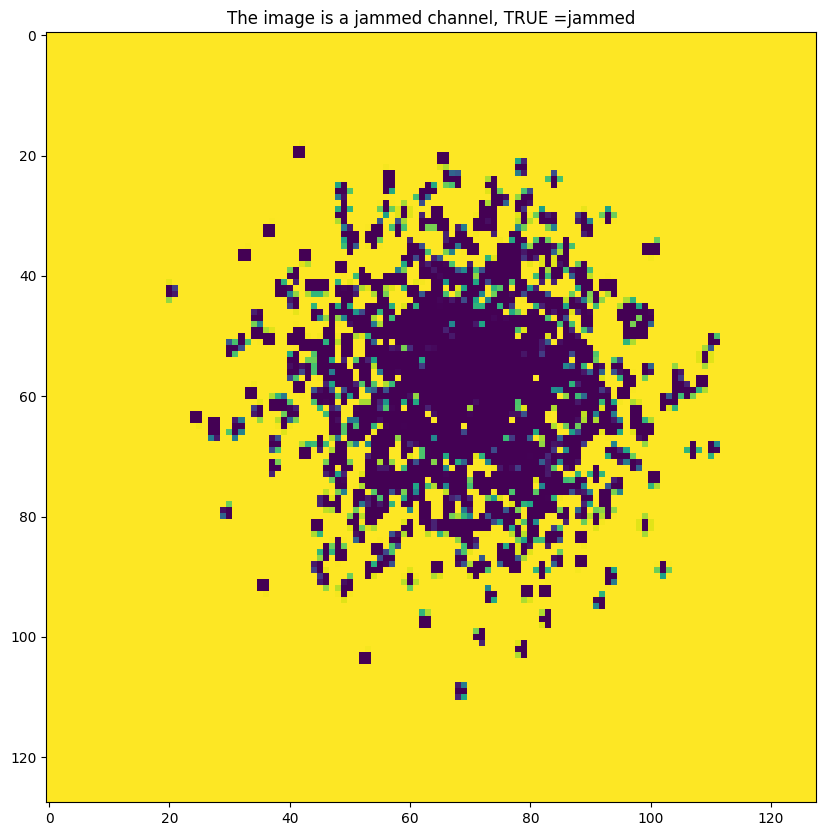

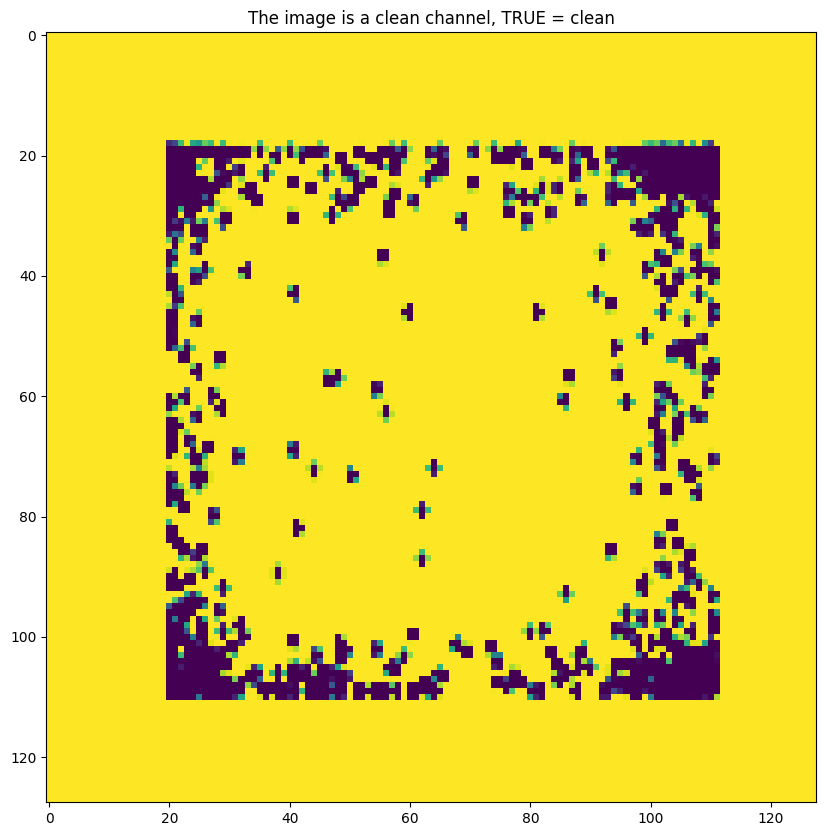

In [19]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [20]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [21]:
values_th=np.arange(min_range_th,max_range_th,0.0002) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

148


In [22]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


  0%|          | 2/800 [00:00<00:54, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


  0%|          | 4/800 [00:00<00:52, 15.28it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0303


  1%|          | 6/800 [00:00<00:53, 14.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0274


  1%|          | 8/800 [00:00<00:51, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0268


  1%|▏         | 10/800 [00:00<00:51, 15.26it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0308


  2%|▏         | 12/800 [00:00<00:51, 15.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


  2%|▏         | 14/800 [00:00<00:50, 15.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0274


  2%|▏         | 16/800 [00:01<00:48, 16.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0270


  2%|▏         | 18/800 [00:01<00:49, 15.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0242


  2%|▎         | 20/800 [00:01<00:48, 16.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


  3%|▎         | 22/800 [00:01<00:47, 16.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


  3%|▎         | 24/800 [00:01<00:49, 15.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


  3%|▎         | 26/800 [00:01<00:48, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0273


  4%|▎         | 28/800 [00:01<00:48, 15.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0296


  4%|▍         | 30/800 [00:01<00:53, 14.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0277


  4%|▍         | 32/800 [00:02<00:56, 13.51it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0283


  4%|▍         | 34/800 [00:02<00:58, 13.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0285


  4%|▍         | 36/800 [00:02<01:00, 12.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0277


  5%|▍         | 38/800 [00:02<01:03, 12.01it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0287


  5%|▌         | 40/800 [00:02<01:04, 11.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0289


  5%|▌         | 42/800 [00:02<01:03, 11.93it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0273


  6%|▌         | 44/800 [00:03<01:03, 11.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0306


  6%|▌         | 46/800 [00:03<01:01, 12.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


  6%|▌         | 48/800 [00:03<00:59, 12.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0282


  6%|▋         | 50/800 [00:03<00:58, 12.92it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0287


  6%|▋         | 52/800 [00:03<01:01, 12.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0262


  7%|▋         | 54/800 [00:03<01:02, 11.93it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0294


  7%|▋         | 56/800 [00:04<01:03, 11.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0295


  7%|▋         | 58/800 [00:04<00:58, 12.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


  8%|▊         | 60/800 [00:04<00:55, 13.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0311


  8%|▊         | 62/800 [00:04<00:53, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0300


  8%|▊         | 64/800 [00:04<00:51, 14.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0284


  8%|▊         | 66/800 [00:04<00:50, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0303


  8%|▊         | 68/800 [00:04<00:48, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


  9%|▉         | 70/800 [00:05<00:49, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


  9%|▉         | 72/800 [00:05<00:46, 15.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0309


  9%|▉         | 74/800 [00:05<00:47, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 10%|▉         | 76/800 [00:05<00:46, 15.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 10%|▉         | 78/800 [00:05<00:48, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0298


 10%|█         | 80/800 [00:05<00:46, 15.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0280


 10%|█         | 82/800 [00:05<00:45, 15.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0293


 10%|█         | 84/800 [00:05<00:44, 16.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0261


 11%|█         | 86/800 [00:06<00:47, 15.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0234


 11%|█         | 88/800 [00:06<00:46, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0323


 11%|█▏        | 90/800 [00:06<00:45, 15.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0298


 12%|█▏        | 92/800 [00:06<00:44, 15.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 12%|█▏        | 94/800 [00:06<00:44, 15.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 12%|█▏        | 96/800 [00:06<00:44, 15.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0294


 12%|█▏        | 98/800 [00:06<00:43, 16.01it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0297


 12%|█▎        | 100/800 [00:06<00:44, 15.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 13%|█▎        | 102/800 [00:07<00:42, 16.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 13%|█▎        | 104/800 [00:07<00:44, 15.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0307


 13%|█▎        | 106/800 [00:07<00:44, 15.57it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0288


 14%|█▎        | 108/800 [00:07<00:44, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 14%|█▍        | 110/800 [00:07<00:44, 15.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0303


 14%|█▍        | 112/800 [00:07<00:44, 15.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0314


 14%|█▍        | 114/800 [00:07<00:45, 15.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0306


 14%|█▍        | 116/800 [00:07<00:43, 15.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0257


 15%|█▍        | 118/800 [00:08<00:42, 16.07it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0272


 15%|█▌        | 120/800 [00:08<00:41, 16.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 15%|█▌        | 122/800 [00:08<00:42, 16.00it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0296


 16%|█▌        | 124/800 [00:08<00:41, 16.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 16%|█▌        | 126/800 [00:08<00:40, 16.60it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0294


 16%|█▌        | 128/800 [00:08<00:41, 16.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 16%|█▋        | 130/800 [00:08<00:42, 15.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 16%|█▋        | 132/800 [00:08<00:42, 15.62it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0310


 17%|█▋        | 134/800 [00:09<00:41, 15.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0265


 17%|█▋        | 136/800 [00:09<00:42, 15.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0229


 17%|█▋        | 138/800 [00:09<00:41, 16.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


 18%|█▊        | 140/800 [00:09<00:41, 15.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0339


 18%|█▊        | 142/800 [00:09<00:42, 15.67it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0257


 18%|█▊        | 144/800 [00:09<00:41, 15.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0307


 18%|█▊        | 146/800 [00:09<00:42, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 18%|█▊        | 148/800 [00:09<00:40, 15.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 19%|█▉        | 150/800 [00:10<00:40, 16.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 19%|█▉        | 152/800 [00:10<00:40, 16.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 19%|█▉        | 154/800 [00:10<00:42, 15.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0293


 20%|█▉        | 156/800 [00:10<00:40, 15.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 20%|█▉        | 158/800 [00:10<00:39, 16.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


 20%|██        | 160/800 [00:10<00:39, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 20%|██        | 162/800 [00:10<00:39, 16.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0278


 20%|██        | 164/800 [00:10<00:40, 15.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0302


 21%|██        | 166/800 [00:11<00:40, 15.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0343


 21%|██        | 168/800 [00:11<00:40, 15.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0302


 21%|██▏       | 170/800 [00:11<00:39, 15.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0317


 22%|██▏       | 172/800 [00:11<00:39, 15.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0266


 22%|██▏       | 174/800 [00:11<00:38, 16.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0285


 22%|██▏       | 176/800 [00:11<00:38, 16.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 22%|██▏       | 178/800 [00:11<00:39, 15.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0284


 22%|██▎       | 180/800 [00:12<00:39, 15.69it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0280


 23%|██▎       | 182/800 [00:12<00:39, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 23%|██▎       | 184/800 [00:12<00:38, 15.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0299


 23%|██▎       | 186/800 [00:12<00:38, 15.78it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0267


 24%|██▎       | 188/800 [00:12<00:39, 15.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 24%|██▍       | 190/800 [00:12<00:37, 16.15it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0240


 24%|██▍       | 192/800 [00:12<00:37, 16.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0304


 24%|██▍       | 194/800 [00:12<00:37, 16.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0268


 24%|██▍       | 196/800 [00:13<00:38, 15.87it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0292


 25%|██▍       | 198/800 [00:13<00:39, 15.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0312


 25%|██▌       | 200/800 [00:13<00:38, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 25%|██▌       | 202/800 [00:13<00:36, 16.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


 26%|██▌       | 204/800 [00:13<00:37, 15.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 26%|██▌       | 206/800 [00:13<00:37, 15.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 26%|██▌       | 208/800 [00:13<00:36, 16.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


 26%|██▋       | 210/800 [00:13<00:36, 16.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0249


 26%|██▋       | 212/800 [00:14<00:37, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 27%|██▋       | 214/800 [00:14<00:37, 15.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0341


 27%|██▋       | 216/800 [00:14<00:39, 14.60it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0309


 27%|██▋       | 218/800 [00:14<00:43, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0250


 28%|██▊       | 220/800 [00:14<00:45, 12.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0288


 28%|██▊       | 222/800 [00:14<00:45, 12.62it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0305


 28%|██▊       | 224/800 [00:15<00:47, 12.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0258


 28%|██▊       | 226/800 [00:15<00:47, 12.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0269


 28%|██▊       | 228/800 [00:15<00:48, 11.85it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0286


 29%|██▉       | 230/800 [00:15<00:48, 11.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0320


 29%|██▉       | 232/800 [00:15<00:47, 12.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0296


 29%|██▉       | 234/800 [00:15<00:47, 11.98it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0315


 30%|██▉       | 236/800 [00:16<00:50, 11.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0283


 30%|██▉       | 238/800 [00:16<00:50, 11.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0262


 30%|███       | 240/800 [00:16<00:50, 11.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


 30%|███       | 242/800 [00:16<00:45, 12.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 30%|███       | 244/800 [00:16<00:42, 12.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 31%|███       | 246/800 [00:16<00:39, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 31%|███       | 248/800 [00:16<00:37, 14.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0332


 31%|███▏      | 250/800 [00:17<00:36, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0308


 32%|███▏      | 252/800 [00:17<00:35, 15.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


 32%|███▏      | 254/800 [00:17<00:35, 15.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0305


 32%|███▏      | 256/800 [00:17<00:35, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0259


 32%|███▏      | 258/800 [00:17<00:35, 15.29it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0260


 32%|███▎      | 260/800 [00:17<00:35, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 33%|███▎      | 262/800 [00:17<00:34, 15.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0300


 33%|███▎      | 264/800 [00:17<00:33, 15.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0297


 33%|███▎      | 266/800 [00:18<00:34, 15.63it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0345


 34%|███▎      | 268/800 [00:18<00:34, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 34%|███▍      | 270/800 [00:18<00:33, 15.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


 34%|███▍      | 272/800 [00:18<00:33, 15.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0295


 34%|███▍      | 274/800 [00:18<00:32, 16.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0280


 34%|███▍      | 276/800 [00:18<00:33, 15.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0260


 35%|███▍      | 278/800 [00:18<00:33, 15.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 35%|███▌      | 280/800 [00:18<00:32, 15.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 35%|███▌      | 282/800 [00:19<00:33, 15.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0265


 36%|███▌      | 284/800 [00:19<00:32, 15.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0297


 36%|███▌      | 286/800 [00:19<00:33, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 36%|███▌      | 288/800 [00:19<00:32, 16.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 36%|███▋      | 290/800 [00:19<00:32, 15.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0229


 36%|███▋      | 292/800 [00:19<00:32, 15.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 37%|███▋      | 294/800 [00:19<00:31, 15.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0302


 37%|███▋      | 296/800 [00:19<00:31, 16.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0232


 37%|███▋      | 298/800 [00:20<00:31, 16.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 38%|███▊      | 300/800 [00:20<00:31, 15.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0265


 38%|███▊      | 302/800 [00:20<00:31, 16.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0304


 38%|███▊      | 304/800 [00:20<00:32, 15.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0262


 38%|███▊      | 306/800 [00:20<00:31, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0258


 38%|███▊      | 308/800 [00:20<00:31, 15.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 39%|███▉      | 310/800 [00:20<00:30, 15.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0310


 39%|███▉      | 312/800 [00:20<00:30, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0260


 39%|███▉      | 314/800 [00:21<00:30, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0323


 40%|███▉      | 316/800 [00:21<00:30, 15.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0269


 40%|███▉      | 318/800 [00:21<00:31, 15.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0284


 40%|████      | 320/800 [00:21<00:31, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0298


 40%|████      | 322/800 [00:21<00:30, 15.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0310


 40%|████      | 324/800 [00:21<00:30, 15.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0288


 41%|████      | 326/800 [00:21<00:30, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0251


 41%|████      | 328/800 [00:21<00:29, 15.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 41%|████▏     | 330/800 [00:22<00:30, 15.36it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0307


 42%|████▏     | 332/800 [00:22<00:29, 15.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 42%|████▏     | 334/800 [00:22<00:29, 15.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 42%|████▏     | 336/800 [00:22<00:29, 15.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 42%|████▏     | 338/800 [00:22<00:29, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 42%|████▎     | 340/800 [00:22<00:29, 15.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0275


 43%|████▎     | 342/800 [00:22<00:28, 16.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 43%|████▎     | 344/800 [00:22<00:28, 16.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0313


 43%|████▎     | 346/800 [00:23<00:28, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 44%|████▎     | 348/800 [00:23<00:28, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0290


 44%|████▍     | 350/800 [00:23<00:28, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 44%|████▍     | 352/800 [00:23<00:28, 15.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 44%|████▍     | 354/800 [00:23<00:29, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 44%|████▍     | 356/800 [00:23<00:29, 14.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0275


 45%|████▍     | 358/800 [00:23<00:29, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0328


 45%|████▌     | 360/800 [00:24<00:28, 15.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 45%|████▌     | 362/800 [00:24<00:28, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 46%|████▌     | 364/800 [00:24<00:28, 15.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 46%|████▌     | 366/800 [00:24<00:28, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0312


 46%|████▌     | 368/800 [00:24<00:27, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0295


 46%|████▋     | 370/800 [00:24<00:26, 15.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0309


 46%|████▋     | 372/800 [00:24<00:26, 15.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


 47%|████▋     | 374/800 [00:24<00:26, 15.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 47%|████▋     | 376/800 [00:25<00:27, 15.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0304


 47%|████▋     | 378/800 [00:25<00:26, 15.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0264


 48%|████▊     | 380/800 [00:25<00:26, 15.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0308


 48%|████▊     | 382/800 [00:25<00:27, 15.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 48%|████▊     | 384/800 [00:25<00:25, 16.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0293


 48%|████▊     | 386/800 [00:25<00:25, 16.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 48%|████▊     | 388/800 [00:25<00:24, 16.50it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 49%|████▉     | 390/800 [00:25<00:24, 16.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 49%|████▉     | 392/800 [00:26<00:24, 16.70it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0302


 49%|████▉     | 394/800 [00:26<00:24, 16.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 50%|████▉     | 396/800 [00:26<00:25, 15.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0282


 50%|████▉     | 398/800 [00:26<00:26, 15.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0257


 50%|█████     | 400/800 [00:26<00:27, 14.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0262


 50%|█████     | 402/800 [00:26<00:30, 12.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0282


 50%|█████     | 404/800 [00:26<00:31, 12.38it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0220


 51%|█████     | 406/800 [00:27<00:32, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0274


 51%|█████     | 408/800 [00:27<00:33, 11.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0286


 51%|█████▏    | 410/800 [00:27<00:32, 12.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0294


 52%|█████▏    | 412/800 [00:27<00:32, 12.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0287


 52%|█████▏    | 414/800 [00:27<00:31, 12.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0259


 52%|█████▏    | 416/800 [00:27<00:31, 12.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0310


 52%|█████▏    | 418/800 [00:28<00:31, 12.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0307


 52%|█████▎    | 420/800 [00:28<00:31, 12.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0262


 53%|█████▎    | 422/800 [00:28<00:31, 12.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0337


 53%|█████▎    | 424/800 [00:28<00:31, 11.78it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0287


 53%|█████▎    | 426/800 [00:28<00:31, 11.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0303


 54%|█████▎    | 428/800 [00:28<00:30, 12.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


 54%|█████▍    | 430/800 [00:29<00:27, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0270


 54%|█████▍    | 432/800 [00:29<00:26, 13.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0363


 54%|█████▍    | 434/800 [00:29<00:25, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0296


 55%|█████▍    | 436/800 [00:29<00:24, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 55%|█████▍    | 438/800 [00:29<00:24, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 55%|█████▌    | 440/800 [00:29<00:24, 14.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0248


 55%|█████▌    | 442/800 [00:29<00:23, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0329


 56%|█████▌    | 444/800 [00:29<00:22, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 56%|█████▌    | 446/800 [00:30<00:22, 15.55it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0263


 56%|█████▌    | 448/800 [00:30<00:23, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 56%|█████▋    | 450/800 [00:30<00:23, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0298


 56%|█████▋    | 452/800 [00:30<00:23, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0279


 57%|█████▋    | 454/800 [00:30<00:22, 15.25it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0276


 57%|█████▋    | 456/800 [00:30<00:21, 15.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


 57%|█████▋    | 458/800 [00:30<00:21, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 57%|█████▊    | 460/800 [00:31<00:21, 15.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0233


 58%|█████▊    | 462/800 [00:31<00:22, 15.17it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0258


 58%|█████▊    | 464/800 [00:31<00:21, 15.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


 58%|█████▊    | 466/800 [00:31<00:22, 14.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0259


 58%|█████▊    | 468/800 [00:31<00:37,  8.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0280


 59%|█████▉    | 470/800 [00:32<00:33,  9.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0252


 59%|█████▉    | 472/800 [00:32<00:30, 10.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0248


 59%|█████▉    | 474/800 [00:32<00:28, 11.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 60%|█████▉    | 476/800 [00:32<00:27, 11.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0292


 60%|█████▉    | 478/800 [00:32<00:25, 12.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 60%|██████    | 480/800 [00:32<00:24, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0278


 60%|██████    | 482/800 [00:32<00:23, 13.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0296


 60%|██████    | 484/800 [00:33<00:24, 13.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0282


 61%|██████    | 486/800 [00:33<00:23, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 61%|██████    | 488/800 [00:33<00:22, 13.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0269


 61%|██████▏   | 490/800 [00:33<00:22, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0283


 62%|██████▏   | 492/800 [00:33<00:22, 13.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0330


 62%|██████▏   | 494/800 [00:33<00:22, 13.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0300


 62%|██████▏   | 496/800 [00:33<00:22, 13.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0270


 62%|██████▏   | 498/800 [00:34<00:22, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0279


 62%|██████▎   | 500/800 [00:34<00:22, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0302


 63%|██████▎   | 502/800 [00:34<00:22, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0279


 63%|██████▎   | 504/800 [00:34<00:22, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0265


 63%|██████▎   | 506/800 [00:34<00:21, 13.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0286


 64%|██████▎   | 508/800 [00:34<00:21, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


 64%|██████▍   | 510/800 [00:34<00:21, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 64%|██████▍   | 512/800 [00:35<00:21, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0376


 64%|██████▍   | 514/800 [00:35<00:20, 13.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0284


 64%|██████▍   | 516/800 [00:35<00:20, 13.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0291


 65%|██████▍   | 518/800 [00:35<00:20, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 65%|██████▌   | 520/800 [00:35<00:20, 13.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0263


 65%|██████▌   | 522/800 [00:35<00:19, 14.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0272


 66%|██████▌   | 524/800 [00:35<00:19, 13.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0273


 66%|██████▌   | 526/800 [00:36<00:20, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0297


 66%|██████▌   | 528/800 [00:36<00:20, 13.57it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0283


 66%|██████▋   | 530/800 [00:36<00:19, 13.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0308


 66%|██████▋   | 532/800 [00:36<00:19, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0301


 67%|██████▋   | 534/800 [00:36<00:19, 13.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0283


 67%|██████▋   | 536/800 [00:36<00:19, 13.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0281


 67%|██████▋   | 538/800 [00:37<00:19, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0283


 68%|██████▊   | 540/800 [00:37<00:19, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0312


 68%|██████▊   | 542/800 [00:37<00:18, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0299


 68%|██████▊   | 544/800 [00:37<00:18, 13.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0265


 68%|██████▊   | 546/800 [00:37<00:18, 13.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0298


 68%|██████▊   | 548/800 [00:37<00:17, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 69%|██████▉   | 550/800 [00:37<00:17, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0325


 69%|██████▉   | 552/800 [00:38<00:17, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


 69%|██████▉   | 554/800 [00:38<00:17, 14.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0315


 70%|██████▉   | 556/800 [00:38<00:16, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 70%|██████▉   | 558/800 [00:38<00:16, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0286


 70%|███████   | 560/800 [00:38<00:16, 14.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0354


 70%|███████   | 562/800 [00:38<00:16, 14.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0262


 70%|███████   | 564/800 [00:38<00:16, 14.66it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0292


 71%|███████   | 566/800 [00:38<00:16, 14.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0290


 71%|███████   | 568/800 [00:39<00:17, 13.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0277


 71%|███████▏  | 570/800 [00:39<00:18, 12.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0257


 72%|███████▏  | 572/800 [00:39<00:18, 12.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0284


 72%|███████▏  | 574/800 [00:39<00:18, 11.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0289


 72%|███████▏  | 576/800 [00:39<00:18, 12.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0267


 72%|███████▏  | 578/800 [00:39<00:17, 12.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0272


 72%|███████▎  | 580/800 [00:40<00:17, 12.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0301


 73%|███████▎  | 582/800 [00:40<00:17, 12.27it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0283


 73%|███████▎  | 584/800 [00:40<00:17, 12.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0260


 73%|███████▎  | 586/800 [00:40<00:18, 11.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0315


 74%|███████▎  | 588/800 [00:40<00:17, 11.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0280


 74%|███████▍  | 590/800 [00:40<00:17, 12.24it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0296


 74%|███████▍  | 592/800 [00:41<00:17, 12.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0322


 74%|███████▍  | 594/800 [00:41<00:17, 12.02it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0299


 74%|███████▍  | 596/800 [00:41<00:17, 11.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0295


 75%|███████▍  | 598/800 [00:41<00:16, 12.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0307


 75%|███████▌  | 600/800 [00:41<00:15, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0335


 75%|███████▌  | 602/800 [00:41<00:14, 13.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


 76%|███████▌  | 604/800 [00:42<00:13, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0288


 76%|███████▌  | 606/800 [00:42<00:13, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0243


 76%|███████▌  | 608/800 [00:42<00:12, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0279


 76%|███████▋  | 610/800 [00:42<00:12, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0288


 76%|███████▋  | 612/800 [00:42<00:12, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


 77%|███████▋  | 614/800 [00:42<00:12, 14.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0328


 77%|███████▋  | 616/800 [00:42<00:12, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 77%|███████▋  | 618/800 [00:42<00:12, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0322


 78%|███████▊  | 620/800 [00:43<00:11, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 78%|███████▊  | 622/800 [00:43<00:11, 15.11it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0300


 78%|███████▊  | 624/800 [00:43<00:11, 15.13it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0335


 78%|███████▊  | 626/800 [00:43<00:11, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 78%|███████▊  | 628/800 [00:43<00:11, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0271


 79%|███████▉  | 630/800 [00:43<00:11, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0302


 79%|███████▉  | 632/800 [00:43<00:11, 14.95it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0272


 79%|███████▉  | 634/800 [00:44<00:11, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0272


 80%|███████▉  | 636/800 [00:44<00:10, 14.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 80%|███████▉  | 638/800 [00:44<00:10, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 80%|████████  | 640/800 [00:44<00:10, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 80%|████████  | 642/800 [00:44<00:10, 14.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0311


 80%|████████  | 644/800 [00:44<00:10, 15.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0232


 81%|████████  | 646/800 [00:44<00:10, 14.92it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0310


 81%|████████  | 648/800 [00:44<00:10, 14.84it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0331


 81%|████████▏ | 650/800 [00:45<00:10, 14.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0309


 82%|████████▏ | 652/800 [00:45<00:09, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 82%|████████▏ | 654/800 [00:45<00:09, 14.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0258


 82%|████████▏ | 656/800 [00:45<00:09, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0269


 82%|████████▏ | 658/800 [00:45<00:09, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 82%|████████▎ | 660/800 [00:45<00:09, 14.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0278


 83%|████████▎ | 662/800 [00:45<00:09, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0291


 83%|████████▎ | 664/800 [00:46<00:09, 14.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


 83%|████████▎ | 666/800 [00:46<00:09, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0253


 84%|████████▎ | 668/800 [00:46<00:08, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 84%|████████▍ | 670/800 [00:46<00:08, 14.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0296


 84%|████████▍ | 672/800 [00:46<00:08, 14.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0307


 84%|████████▍ | 674/800 [00:46<00:08, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0306


 84%|████████▍ | 676/800 [00:46<00:08, 15.17it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0300


 85%|████████▍ | 678/800 [00:46<00:07, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 85%|████████▌ | 680/800 [00:47<00:07, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 85%|████████▌ | 682/800 [00:47<00:07, 15.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0260


 86%|████████▌ | 684/800 [00:47<00:07, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0252


 86%|████████▌ | 686/800 [00:47<00:07, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0337


 86%|████████▌ | 688/800 [00:47<00:07, 14.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0298


 86%|████████▋ | 690/800 [00:47<00:07, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 86%|████████▋ | 692/800 [00:47<00:07, 14.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0316


 87%|████████▋ | 694/800 [00:48<00:07, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0314


 87%|████████▋ | 696/800 [00:48<00:06, 14.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0285


 87%|████████▋ | 698/800 [00:48<00:06, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0285


 88%|████████▊ | 700/800 [00:48<00:06, 14.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0272


 88%|████████▊ | 702/800 [00:48<00:06, 14.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0309


 88%|████████▊ | 704/800 [00:48<00:06, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 88%|████████▊ | 706/800 [00:48<00:06, 14.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0328


 88%|████████▊ | 708/800 [00:49<00:06, 14.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0265


 89%|████████▉ | 710/800 [00:49<00:06, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0238


 89%|████████▉ | 712/800 [00:49<00:05, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 89%|████████▉ | 714/800 [00:49<00:05, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 90%|████████▉ | 716/800 [00:49<00:05, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0276


 90%|████████▉ | 718/800 [00:49<00:05, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0272


 90%|█████████ | 720/800 [00:49<00:05, 14.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0293


 90%|█████████ | 722/800 [00:49<00:05, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0232


 90%|█████████ | 724/800 [00:50<00:05, 14.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0260


 91%|█████████ | 726/800 [00:50<00:05, 14.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0261


 91%|█████████ | 728/800 [00:50<00:04, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0272


 91%|█████████▏| 730/800 [00:50<00:04, 14.68it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0341


 92%|█████████▏| 732/800 [00:50<00:04, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 92%|█████████▏| 734/800 [00:50<00:04, 14.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0274


 92%|█████████▏| 736/800 [00:50<00:04, 15.54it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0285


 92%|█████████▏| 738/800 [00:51<00:03, 15.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0261


 92%|█████████▎| 740/800 [00:51<00:03, 15.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0267


 93%|█████████▎| 742/800 [00:51<00:03, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0271


 93%|█████████▎| 744/800 [00:51<00:03, 14.95it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0283


 93%|█████████▎| 746/800 [00:51<00:03, 14.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 94%|█████████▎| 748/800 [00:51<00:03, 13.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0290


 94%|█████████▍| 750/800 [00:51<00:03, 12.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0291


 94%|█████████▍| 752/800 [00:52<00:03, 12.47it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0296


 94%|█████████▍| 754/800 [00:52<00:03, 12.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0290


 94%|█████████▍| 756/800 [00:52<00:03, 11.72it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0303


 95%|█████████▍| 758/800 [00:52<00:03, 11.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0283


 95%|█████████▌| 760/800 [00:52<00:03, 11.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0289


 95%|█████████▌| 762/800 [00:53<00:03, 11.26it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0309


 96%|█████████▌| 764/800 [00:53<00:03, 11.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0268


 96%|█████████▌| 766/800 [00:53<00:03, 11.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0293


 96%|█████████▌| 768/800 [00:53<00:02, 10.76it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0243


 96%|█████████▋| 770/800 [00:53<00:02, 11.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0290


 96%|█████████▋| 772/800 [00:53<00:02, 10.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0287


 97%|█████████▋| 774/800 [00:54<00:02, 10.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 97%|█████████▋| 776/800 [00:54<00:02, 10.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0312


 97%|█████████▋| 778/800 [00:54<00:01, 11.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


 98%|█████████▊| 780/800 [00:54<00:01, 12.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0245


 98%|█████████▊| 782/800 [00:54<00:01, 13.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0312


 98%|█████████▊| 784/800 [00:54<00:01, 13.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0263


 98%|█████████▊| 786/800 [00:55<00:01, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 98%|█████████▊| 788/800 [00:55<00:00, 13.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0298


 99%|█████████▉| 790/800 [00:55<00:00, 14.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0310


 99%|█████████▉| 792/800 [00:55<00:00, 14.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 99%|█████████▉| 794/800 [00:55<00:00, 14.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0257


100%|█████████▉| 796/800 [00:55<00:00, 14.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


100%|█████████▉| 798/800 [00:55<00:00, 15.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0268


100%|██████████| 800/800 [00:55<00:00, 14.30it/s]

800


In [23]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [24]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [25]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00125, 0.00125, 0.0025, 0.0025, 0.00375, 0.005, 0.005, 0.00625, 0.01, 0.02, 0.025, 0.02625, 0.03125, 0.03875, 0.04875, 0.06125, 0.06625, 0.08125, 0.095, 0.1075, 0.11875, 0.13625, 0.15875, 0.1875, 0.20625, 0.24125, 0.25875, 0.275, 0.295, 0.3125, 0.33875, 0.35625, 0.37625, 0.39375, 0.41625, 0.42875, 0.435, 0.4425, 0.44375, 0.44875, 0.45625, 0.45875, 0.46, 0.465, 0.46875, 0.47125, 0.4725, 0.475, 0.48, 0.48375, 0.48625, 0.48875, 0.49, 0.49125, 0.49125, 0.49125, 0.49375, 0.49375, 0.49375, 0.495, 0.49625, 0.4975, 0.4975, 0.4975, 0.4975, 0.4975, 0.4975, 0.49875, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5, 0.49875, 0

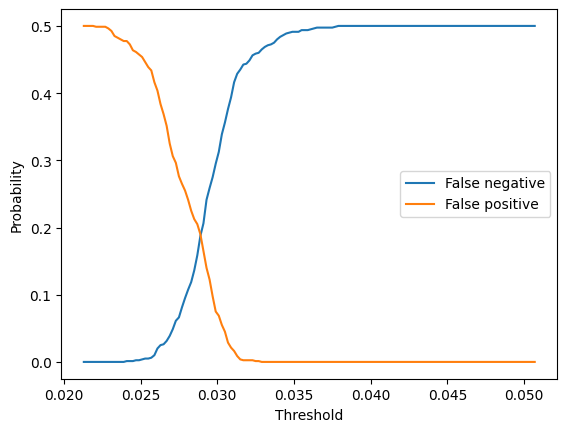

In [26]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [27]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0236


  0%|          | 2/800 [00:00<00:46, 17.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0311


  0%|          | 4/800 [00:00<00:45, 17.59it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0303


  1%|          | 6/800 [00:00<00:47, 16.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0274


  1%|          | 8/800 [00:00<00:50, 15.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


  1%|▏         | 10/800 [00:00<00:49, 16.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0308


  2%|▏         | 12/800 [00:00<00:48, 16.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


  2%|▏         | 14/800 [00:00<00:48, 16.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


  2%|▏         | 16/800 [00:00<00:48, 16.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0270


  2%|▏         | 18/800 [00:01<00:47, 16.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0242


  2%|▎         | 20/800 [00:01<00:48, 16.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0300


  3%|▎         | 22/800 [00:01<00:48, 15.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


  3%|▎         | 24/800 [00:01<00:49, 15.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


  3%|▎         | 26/800 [00:01<00:48, 15.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0273


  4%|▎         | 28/800 [00:01<00:49, 15.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0296


  4%|▍         | 30/800 [00:01<00:49, 15.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0277


  4%|▍         | 32/800 [00:02<00:50, 15.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0283


  4%|▍         | 34/800 [00:02<00:49, 15.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


  4%|▍         | 36/800 [00:02<00:48, 15.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


  5%|▍         | 38/800 [00:02<00:48, 15.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


  5%|▌         | 40/800 [00:02<00:50, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


  5%|▌         | 42/800 [00:02<00:50, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0273


  6%|▌         | 44/800 [00:02<00:49, 15.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0306


  6%|▌         | 46/800 [00:02<00:47, 15.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


  6%|▌         | 48/800 [00:03<00:46, 16.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


  6%|▋         | 50/800 [00:03<00:46, 16.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


  6%|▋         | 52/800 [00:03<00:45, 16.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


  7%|▋         | 54/800 [00:03<00:46, 16.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0294


  7%|▋         | 56/800 [00:03<00:45, 16.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0295


  7%|▋         | 58/800 [00:03<00:47, 15.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0266


  8%|▊         | 60/800 [00:03<00:47, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0311


  8%|▊         | 62/800 [00:03<00:47, 15.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


  8%|▊         | 64/800 [00:04<00:47, 15.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


  8%|▊         | 66/800 [00:04<00:47, 15.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


  8%|▊         | 68/800 [00:04<00:47, 15.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


  9%|▉         | 70/800 [00:04<00:45, 15.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


  9%|▉         | 72/800 [00:04<00:45, 15.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0309


  9%|▉         | 74/800 [00:04<00:45, 15.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 10%|▉         | 76/800 [00:04<00:47, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 10%|▉         | 78/800 [00:04<00:46, 15.41it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0298


 10%|█         | 80/800 [00:05<00:47, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0280


 10%|█         | 82/800 [00:05<00:48, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 10%|█         | 84/800 [00:05<00:46, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


 11%|█         | 86/800 [00:05<00:47, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0234


 11%|█         | 88/800 [00:05<00:46, 15.29it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0323


 11%|█▏        | 90/800 [00:05<00:46, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 12%|█▏        | 92/800 [00:05<00:48, 14.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0287


 12%|█▏        | 94/800 [00:06<00:48, 14.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0280


 12%|█▏        | 96/800 [00:06<00:47, 14.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 12%|█▏        | 98/800 [00:06<00:46, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 12%|█▎        | 100/800 [00:06<00:46, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0277


 13%|█▎        | 102/800 [00:06<00:47, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 13%|█▎        | 104/800 [00:06<00:47, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0307


 13%|█▎        | 106/800 [00:06<00:46, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0288


 14%|█▎        | 108/800 [00:06<00:46, 14.96it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0293


 14%|█▍        | 110/800 [00:07<00:44, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0303


 14%|█▍        | 112/800 [00:07<00:44, 15.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0314


 14%|█▍        | 114/800 [00:07<00:43, 15.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0306


 14%|█▍        | 116/800 [00:07<00:43, 15.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0257


 15%|█▍        | 118/800 [00:07<00:43, 15.59it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0272


 15%|█▌        | 120/800 [00:07<00:43, 15.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0286


 15%|█▌        | 122/800 [00:07<00:43, 15.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 16%|█▌        | 124/800 [00:07<00:44, 15.21it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0289


 16%|█▌        | 126/800 [00:08<00:49, 13.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0294


 16%|█▌        | 128/800 [00:08<00:51, 12.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0302


 16%|█▋        | 130/800 [00:08<00:53, 12.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0287


 16%|█▋        | 132/800 [00:08<00:54, 12.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0310


 17%|█▋        | 134/800 [00:08<00:57, 11.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0265


 17%|█▋        | 136/800 [00:09<00:58, 11.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0229


 17%|█▋        | 138/800 [00:09<00:58, 11.23it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0273


 18%|█▊        | 140/800 [00:09<00:58, 11.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0339


 18%|█▊        | 142/800 [00:09<00:57, 11.40it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0257


 18%|█▊        | 144/800 [00:09<00:57, 11.42it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0307


 18%|█▊        | 146/800 [00:09<00:58, 11.24it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0259


 18%|█▊        | 148/800 [00:10<00:58, 11.15it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0270


 19%|█▉        | 150/800 [00:10<00:55, 11.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 19%|█▉        | 152/800 [00:10<00:51, 12.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0292


 19%|█▉        | 154/800 [00:10<00:48, 13.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0293


 20%|█▉        | 156/800 [00:10<00:46, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 20%|█▉        | 158/800 [00:10<00:44, 14.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0266


 20%|██        | 160/800 [00:10<00:44, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0292


 20%|██        | 162/800 [00:11<00:43, 14.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0278


 20%|██        | 164/800 [00:11<00:41, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 21%|██        | 166/800 [00:11<00:40, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0343


 21%|██        | 168/800 [00:11<00:40, 15.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0302


 21%|██▏       | 170/800 [00:11<00:40, 15.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0317


 22%|██▏       | 172/800 [00:11<00:40, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0266


 22%|██▏       | 174/800 [00:11<00:40, 15.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 22%|██▏       | 176/800 [00:11<00:41, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0269


 22%|██▏       | 178/800 [00:12<00:41, 15.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0284


 22%|██▎       | 180/800 [00:12<00:41, 14.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 23%|██▎       | 182/800 [00:12<00:40, 15.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0306


 23%|██▎       | 184/800 [00:12<00:40, 15.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 23%|██▎       | 186/800 [00:12<00:39, 15.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0267


 24%|██▎       | 188/800 [00:12<00:39, 15.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0290


 24%|██▍       | 190/800 [00:12<00:39, 15.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0240


 24%|██▍       | 192/800 [00:13<00:40, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 24%|██▍       | 194/800 [00:13<00:39, 15.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0268


 24%|██▍       | 196/800 [00:13<00:40, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 25%|██▍       | 198/800 [00:13<00:39, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0312


 25%|██▌       | 200/800 [00:13<00:38, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0274


 25%|██▌       | 202/800 [00:13<00:37, 15.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 26%|██▌       | 204/800 [00:13<00:37, 15.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0297


 26%|██▌       | 206/800 [00:13<00:38, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 26%|██▌       | 208/800 [00:14<00:38, 15.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0306


 26%|██▋       | 210/800 [00:14<00:38, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0249


 26%|██▋       | 212/800 [00:14<00:37, 15.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


 27%|██▋       | 214/800 [00:14<00:38, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0341


 27%|██▋       | 216/800 [00:14<00:38, 15.24it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0309


 27%|██▋       | 218/800 [00:14<00:38, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0250


 28%|██▊       | 220/800 [00:14<00:37, 15.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0288


 28%|██▊       | 222/800 [00:14<00:38, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0305


 28%|██▊       | 224/800 [00:15<00:38, 15.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0258


 28%|██▊       | 226/800 [00:15<00:37, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0269


 28%|██▊       | 228/800 [00:15<00:37, 15.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0286


 29%|██▉       | 230/800 [00:15<00:37, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 29%|██▉       | 232/800 [00:15<00:37, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0296


 29%|██▉       | 234/800 [00:15<00:37, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0315


 30%|██▉       | 236/800 [00:15<00:37, 15.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 30%|██▉       | 238/800 [00:16<00:37, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0262


 30%|███       | 240/800 [00:16<00:36, 15.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0263


 30%|███       | 242/800 [00:16<00:36, 15.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0294


 30%|███       | 244/800 [00:16<00:35, 15.61it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0293


 31%|███       | 246/800 [00:16<00:35, 15.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0292


 31%|███       | 248/800 [00:16<00:35, 15.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0332


 31%|███▏      | 250/800 [00:16<00:35, 15.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0308


 32%|███▏      | 252/800 [00:16<00:35, 15.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 32%|███▏      | 254/800 [00:17<00:35, 15.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


 32%|███▏      | 256/800 [00:17<00:34, 15.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0259


 32%|███▏      | 258/800 [00:17<00:35, 15.40it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0260


 32%|███▎      | 260/800 [00:17<00:33, 16.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0274


 33%|███▎      | 262/800 [00:17<00:33, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 33%|███▎      | 264/800 [00:17<00:33, 16.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0297


 33%|███▎      | 266/800 [00:17<00:33, 15.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0345


 34%|███▎      | 268/800 [00:17<00:34, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0290


 34%|███▍      | 270/800 [00:18<00:33, 15.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0306


 34%|███▍      | 272/800 [00:18<00:33, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 34%|███▍      | 274/800 [00:18<00:34, 15.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0280


 34%|███▍      | 276/800 [00:18<00:34, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0260


 35%|███▍      | 278/800 [00:18<00:33, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 35%|███▌      | 280/800 [00:18<00:32, 16.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0300


 35%|███▌      | 282/800 [00:18<00:32, 15.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 36%|███▌      | 284/800 [00:18<00:33, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 36%|███▌      | 286/800 [00:19<00:32, 15.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 36%|███▌      | 288/800 [00:19<00:32, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 36%|███▋      | 290/800 [00:19<00:32, 15.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0229


 36%|███▋      | 292/800 [00:19<00:33, 15.33it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0296


 37%|███▋      | 294/800 [00:19<00:32, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


 37%|███▋      | 296/800 [00:19<00:32, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0232


 37%|███▋      | 298/800 [00:19<00:32, 15.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0281


 38%|███▊      | 300/800 [00:20<00:32, 15.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0265


 38%|███▊      | 302/800 [00:20<00:32, 15.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0304


 38%|███▊      | 304/800 [00:20<00:32, 15.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0262


 38%|███▊      | 306/800 [00:20<00:35, 14.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0258


 38%|███▊      | 308/800 [00:20<00:37, 13.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0269


 39%|███▉      | 310/800 [00:20<00:39, 12.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0310


 39%|███▉      | 312/800 [00:20<00:39, 12.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0260


 39%|███▉      | 314/800 [00:21<00:42, 11.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0323


 40%|███▉      | 316/800 [00:21<00:42, 11.47it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0269


 40%|███▉      | 318/800 [00:21<00:41, 11.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0284


 40%|████      | 320/800 [00:21<00:41, 11.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


 40%|████      | 322/800 [00:21<00:40, 11.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0310


 40%|████      | 324/800 [00:22<00:40, 11.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0288


 41%|████      | 326/800 [00:22<00:41, 11.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0251


 41%|████      | 328/800 [00:22<00:41, 11.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0299


 41%|████▏     | 330/800 [00:22<00:41, 11.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0307


 42%|████▏     | 332/800 [00:22<00:37, 12.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


 42%|████▏     | 334/800 [00:22<00:35, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0281


 42%|████▏     | 336/800 [00:22<00:35, 13.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0255


 42%|████▏     | 338/800 [00:23<00:33, 13.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


 42%|████▎     | 340/800 [00:23<00:32, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 43%|████▎     | 342/800 [00:23<00:30, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0291


 43%|████▎     | 344/800 [00:23<00:30, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0313


 43%|████▎     | 346/800 [00:23<00:30, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0299


 44%|████▎     | 348/800 [00:23<00:29, 15.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0290


 44%|████▍     | 350/800 [00:23<00:28, 15.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0252


 44%|████▍     | 352/800 [00:24<00:30, 14.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0292


 44%|████▍     | 354/800 [00:24<00:30, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0289


 44%|████▍     | 356/800 [00:24<00:29, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0275


 45%|████▍     | 358/800 [00:24<00:29, 15.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0328


 45%|████▌     | 360/800 [00:24<00:29, 14.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 45%|████▌     | 362/800 [00:24<00:29, 14.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0291


 46%|████▌     | 364/800 [00:24<00:28, 15.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0272


 46%|████▌     | 366/800 [00:24<00:27, 15.64it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0312


 46%|████▌     | 368/800 [00:25<00:27, 15.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0295


 46%|████▋     | 370/800 [00:25<00:27, 15.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0309


 46%|████▋     | 372/800 [00:25<00:27, 15.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0266


 47%|████▋     | 374/800 [00:25<00:27, 15.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0282


 47%|████▋     | 376/800 [00:25<00:27, 15.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 47%|████▋     | 378/800 [00:25<00:27, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0264


 48%|████▊     | 380/800 [00:25<00:27, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0308


 48%|████▊     | 382/800 [00:25<00:26, 15.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 48%|████▊     | 384/800 [00:26<00:27, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 48%|████▊     | 386/800 [00:26<00:27, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0289


 48%|████▊     | 388/800 [00:26<00:27, 15.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 49%|████▉     | 390/800 [00:26<00:27, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0266


 49%|████▉     | 392/800 [00:26<00:26, 15.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0302


 49%|████▉     | 394/800 [00:26<00:26, 15.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0288


 50%|████▉     | 396/800 [00:26<00:26, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 50%|████▉     | 398/800 [00:26<00:25, 16.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0257


 50%|█████     | 400/800 [00:27<00:25, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0262


 50%|█████     | 402/800 [00:27<00:25, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0282


 50%|█████     | 404/800 [00:27<00:25, 15.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0220


 51%|█████     | 406/800 [00:27<00:25, 15.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0274


 51%|█████     | 408/800 [00:27<00:25, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0286


 51%|█████▏    | 410/800 [00:27<00:25, 15.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0294


 52%|█████▏    | 412/800 [00:27<00:25, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0287


 52%|█████▏    | 414/800 [00:28<00:25, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0259


 52%|█████▏    | 416/800 [00:28<00:24, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0310


 52%|█████▏    | 418/800 [00:28<00:25, 14.99it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0307


 52%|█████▎    | 420/800 [00:28<00:24, 15.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0262


 53%|█████▎    | 422/800 [00:28<00:24, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0337


 53%|█████▎    | 424/800 [00:28<00:23, 15.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 53%|█████▎    | 426/800 [00:28<00:24, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0303


 54%|█████▎    | 428/800 [00:28<00:24, 15.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0270


 54%|█████▍    | 430/800 [00:29<00:24, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0270


 54%|█████▍    | 432/800 [00:29<00:23, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0363


 54%|█████▍    | 434/800 [00:29<00:23, 15.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 55%|█████▍    | 436/800 [00:29<00:23, 15.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0293


 55%|█████▍    | 438/800 [00:29<00:23, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0275


 55%|█████▌    | 440/800 [00:29<00:23, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0248


 55%|█████▌    | 442/800 [00:29<00:23, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0329


 56%|█████▌    | 444/800 [00:29<00:22, 15.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0302


 56%|█████▌    | 446/800 [00:30<00:22, 15.41it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0263


 56%|█████▌    | 448/800 [00:30<00:22, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0296


 56%|█████▋    | 450/800 [00:30<00:23, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0298


 56%|█████▋    | 452/800 [00:30<00:22, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0279


 57%|█████▋    | 454/800 [00:30<00:22, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0276


 57%|█████▋    | 456/800 [00:30<00:22, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


 57%|█████▋    | 458/800 [00:30<00:22, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 57%|█████▊    | 460/800 [00:31<00:21, 15.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0233


 58%|█████▊    | 462/800 [00:31<00:21, 15.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0258


 58%|█████▊    | 464/800 [00:31<00:21, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0305


 58%|█████▊    | 466/800 [00:31<00:21, 15.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0259


 58%|█████▊    | 468/800 [00:31<00:21, 15.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0280


 59%|█████▉    | 470/800 [00:31<00:21, 15.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0252


 59%|█████▉    | 472/800 [00:31<00:20, 15.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0248


 59%|█████▉    | 474/800 [00:31<00:21, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0305


 60%|█████▉    | 476/800 [00:32<00:20, 15.59it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0292


 60%|█████▉    | 478/800 [00:32<00:20, 15.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0294


 60%|██████    | 480/800 [00:32<00:20, 15.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0278


 60%|██████    | 482/800 [00:32<00:20, 15.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0296


 60%|██████    | 484/800 [00:32<00:21, 14.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0282


 61%|██████    | 486/800 [00:32<00:22, 14.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0292


 61%|██████    | 488/800 [00:32<00:23, 13.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0269


 61%|██████▏   | 490/800 [00:33<00:24, 12.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0283


 62%|██████▏   | 492/800 [00:33<00:24, 12.35it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0330


 62%|██████▏   | 494/800 [00:33<00:25, 12.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0300


 62%|██████▏   | 496/800 [00:33<00:24, 12.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0270


 62%|██████▏   | 498/800 [00:33<00:24, 12.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0279


 62%|██████▎   | 500/800 [00:33<00:24, 12.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0302


 63%|██████▎   | 502/800 [00:34<00:24, 12.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0279


 63%|██████▎   | 504/800 [00:34<00:24, 12.31it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0265


 63%|██████▎   | 506/800 [00:34<00:24, 11.81it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0286


 64%|██████▎   | 508/800 [00:34<00:25, 11.65it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0305


 64%|██████▍   | 510/800 [00:34<00:24, 11.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0291


 64%|██████▍   | 512/800 [00:34<00:24, 11.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0376


 64%|██████▍   | 514/800 [00:35<00:23, 12.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0284


 64%|██████▍   | 516/800 [00:35<00:21, 13.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0291


 65%|██████▍   | 518/800 [00:35<00:21, 13.17it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0287


 65%|██████▌   | 520/800 [00:35<00:19, 14.02it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0263


 65%|██████▌   | 522/800 [00:35<00:18, 14.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0272


 66%|██████▌   | 524/800 [00:35<00:18, 15.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0273


 66%|██████▌   | 526/800 [00:35<00:18, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0297


 66%|██████▌   | 528/800 [00:36<00:17, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0283


 66%|██████▋   | 530/800 [00:36<00:17, 15.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0308


 66%|██████▋   | 532/800 [00:36<00:17, 15.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 67%|██████▋   | 534/800 [00:36<00:17, 15.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0283


 67%|██████▋   | 536/800 [00:36<00:30,  8.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0281


 67%|██████▋   | 538/800 [00:36<00:26,  9.92it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0283


 68%|██████▊   | 540/800 [00:37<00:24, 10.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0312


 68%|██████▊   | 542/800 [00:37<00:22, 11.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0299


 68%|██████▊   | 544/800 [00:37<00:21, 11.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0265


 68%|██████▊   | 546/800 [00:37<00:20, 12.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0298


 68%|██████▊   | 548/800 [00:37<00:19, 12.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0289


 69%|██████▉   | 550/800 [00:37<00:19, 12.76it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0325


 69%|██████▉   | 552/800 [00:38<00:19, 12.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0310


 69%|██████▉   | 554/800 [00:38<00:19, 12.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0315


 70%|██████▉   | 556/800 [00:38<00:18, 13.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0276


 70%|██████▉   | 558/800 [00:38<00:18, 13.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0286


 70%|███████   | 560/800 [00:38<00:18, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0354


 70%|███████   | 562/800 [00:38<00:17, 13.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0262


 70%|███████   | 564/800 [00:38<00:17, 13.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0292


 71%|███████   | 566/800 [00:39<00:17, 13.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0290


 71%|███████   | 568/800 [00:39<00:17, 13.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0277


 71%|███████▏  | 570/800 [00:39<00:17, 13.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0257


 72%|███████▏  | 572/800 [00:39<00:17, 13.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0284


 72%|███████▏  | 574/800 [00:39<00:16, 13.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0289


 72%|███████▏  | 576/800 [00:39<00:16, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0267


 72%|███████▏  | 578/800 [00:39<00:16, 13.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0272


 72%|███████▎  | 580/800 [00:40<00:16, 13.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0301


 73%|███████▎  | 582/800 [00:40<00:16, 13.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 73%|███████▎  | 584/800 [00:40<00:15, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0260


 73%|███████▎  | 586/800 [00:40<00:15, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0315


 74%|███████▎  | 588/800 [00:40<00:15, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0280


 74%|███████▍  | 590/800 [00:40<00:15, 13.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0296


 74%|███████▍  | 592/800 [00:41<00:15, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0322


 74%|███████▍  | 594/800 [00:41<00:15, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0299


 74%|███████▍  | 596/800 [00:41<00:14, 13.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0295


 75%|███████▍  | 598/800 [00:41<00:14, 13.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0307


 75%|███████▌  | 600/800 [00:41<00:14, 13.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0335


 75%|███████▌  | 602/800 [00:41<00:14, 13.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0306


 76%|███████▌  | 604/800 [00:41<00:14, 13.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0288


 76%|███████▌  | 606/800 [00:42<00:13, 14.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0243


 76%|███████▌  | 608/800 [00:42<00:13, 14.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0279


 76%|███████▋  | 610/800 [00:42<00:13, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0288


 76%|███████▋  | 612/800 [00:42<00:13, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0277


 77%|███████▋  | 614/800 [00:42<00:12, 14.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0328


 77%|███████▋  | 616/800 [00:42<00:12, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0313


 77%|███████▋  | 618/800 [00:42<00:11, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0322


 78%|███████▊  | 620/800 [00:42<00:11, 15.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


 78%|███████▊  | 622/800 [00:43<00:11, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0300


 78%|███████▊  | 624/800 [00:43<00:11, 15.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0335


 78%|███████▊  | 626/800 [00:43<00:11, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0313


 78%|███████▊  | 628/800 [00:43<00:11, 15.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0271


 79%|███████▉  | 630/800 [00:43<00:11, 15.28it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0302


 79%|███████▉  | 632/800 [00:43<00:10, 15.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0272


 79%|███████▉  | 634/800 [00:43<00:10, 15.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0272


 80%|███████▉  | 636/800 [00:43<00:11, 14.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0291


 80%|███████▉  | 638/800 [00:44<00:11, 14.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0299


 80%|████████  | 640/800 [00:44<00:10, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0268


 80%|████████  | 642/800 [00:44<00:10, 15.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0311


 80%|████████  | 644/800 [00:44<00:10, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0232


 81%|████████  | 646/800 [00:44<00:10, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0310


 81%|████████  | 648/800 [00:44<00:10, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0331


 81%|████████▏ | 650/800 [00:44<00:09, 15.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 82%|████████▏ | 652/800 [00:45<00:09, 15.06it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0289


 82%|████████▏ | 654/800 [00:45<00:10, 13.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0258


 82%|████████▏ | 656/800 [00:45<00:10, 13.11it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0269


 82%|████████▏ | 658/800 [00:45<00:11, 12.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0291


 82%|████████▎ | 660/800 [00:45<00:11, 12.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0278


 83%|████████▎ | 662/800 [00:45<00:11, 11.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0291


 83%|████████▎ | 664/800 [00:46<00:11, 12.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0306


 83%|████████▎ | 666/800 [00:46<00:11, 11.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0253


 84%|████████▎ | 668/800 [00:46<00:10, 12.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0294


 84%|████████▍ | 670/800 [00:46<00:10, 12.17it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0296


 84%|████████▍ | 672/800 [00:46<00:10, 11.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0307


 84%|████████▍ | 674/800 [00:46<00:10, 12.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0306


 84%|████████▍ | 676/800 [00:47<00:10, 12.04it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0300


 85%|████████▍ | 678/800 [00:47<00:10, 11.59it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0306


 85%|████████▌ | 680/800 [00:47<00:10, 11.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0297


 85%|████████▌ | 682/800 [00:47<00:10, 11.50it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0260


 86%|████████▌ | 684/800 [00:47<00:09, 12.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0252


 86%|████████▌ | 686/800 [00:47<00:08, 13.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0337


 86%|████████▌ | 688/800 [00:48<00:08, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0298


 86%|████████▋ | 690/800 [00:48<00:07, 14.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 86%|████████▋ | 692/800 [00:48<00:07, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0316


 87%|████████▋ | 694/800 [00:48<00:07, 14.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0314


 87%|████████▋ | 696/800 [00:48<00:07, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0285


 87%|████████▋ | 698/800 [00:48<00:07, 14.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0285


 88%|████████▊ | 700/800 [00:48<00:06, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0272


 88%|████████▊ | 702/800 [00:48<00:06, 14.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0309


 88%|████████▊ | 704/800 [00:49<00:06, 14.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0290


 88%|████████▊ | 706/800 [00:49<00:06, 15.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0328


 88%|████████▊ | 708/800 [00:49<00:06, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0265


 89%|████████▉ | 710/800 [00:49<00:06, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0238


 89%|████████▉ | 712/800 [00:49<00:05, 15.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0289


 89%|████████▉ | 714/800 [00:49<00:05, 15.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0283


 90%|████████▉ | 716/800 [00:49<00:05, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0276


 90%|████████▉ | 718/800 [00:50<00:05, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0272


 90%|█████████ | 720/800 [00:50<00:05, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 90%|█████████ | 722/800 [00:50<00:05, 14.97it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0232


 90%|█████████ | 724/800 [00:50<00:05, 15.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0260


 91%|█████████ | 726/800 [00:50<00:04, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


 91%|█████████ | 728/800 [00:50<00:04, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0272


 91%|█████████▏| 730/800 [00:50<00:04, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0341


 92%|█████████▏| 732/800 [00:50<00:04, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0292


 92%|█████████▏| 734/800 [00:51<00:04, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0274


 92%|█████████▏| 736/800 [00:51<00:04, 15.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0285


 92%|█████████▏| 738/800 [00:51<00:04, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0261


 92%|█████████▎| 740/800 [00:51<00:03, 15.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0267


 93%|█████████▎| 742/800 [00:51<00:03, 15.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0271


 93%|█████████▎| 744/800 [00:51<00:03, 15.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0283


 93%|█████████▎| 746/800 [00:51<00:03, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0279


 94%|█████████▎| 748/800 [00:52<00:03, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 94%|█████████▍| 750/800 [00:52<00:03, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0291


 94%|█████████▍| 752/800 [00:52<00:03, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0296


 94%|█████████▍| 754/800 [00:52<00:03, 15.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0290


 94%|█████████▍| 756/800 [00:52<00:02, 14.95it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0303


 95%|█████████▍| 758/800 [00:52<00:02, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0283


 95%|█████████▌| 760/800 [00:52<00:02, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0289


 95%|█████████▌| 762/800 [00:52<00:02, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 96%|█████████▌| 764/800 [00:53<00:02, 14.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0268


 96%|█████████▌| 766/800 [00:53<00:02, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


 96%|█████████▌| 768/800 [00:53<00:02, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0243


 96%|█████████▋| 770/800 [00:53<00:02, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0290


 96%|█████████▋| 772/800 [00:53<00:01, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0287


 97%|█████████▋| 774/800 [00:53<00:01, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0287


 97%|█████████▋| 776/800 [00:53<00:01, 14.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0312


 97%|█████████▋| 778/800 [00:54<00:01, 15.07it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0266


 98%|█████████▊| 780/800 [00:54<00:01, 14.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0245


 98%|█████████▊| 782/800 [00:54<00:01, 14.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0312


 98%|█████████▊| 784/800 [00:54<00:01, 15.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0263


 98%|█████████▊| 786/800 [00:54<00:00, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 98%|█████████▊| 788/800 [00:54<00:00, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0298


 99%|█████████▉| 790/800 [00:54<00:00, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 99%|█████████▉| 792/800 [00:54<00:00, 15.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0313


 99%|█████████▉| 794/800 [00:55<00:00, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0257


100%|█████████▉| 796/800 [00:55<00:00, 15.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0263


100%|█████████▉| 798/800 [00:55<00:00, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0268


100%|██████████| 800/800 [00:55<00:00, 14.42it/s]


In [28]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 59.875 %


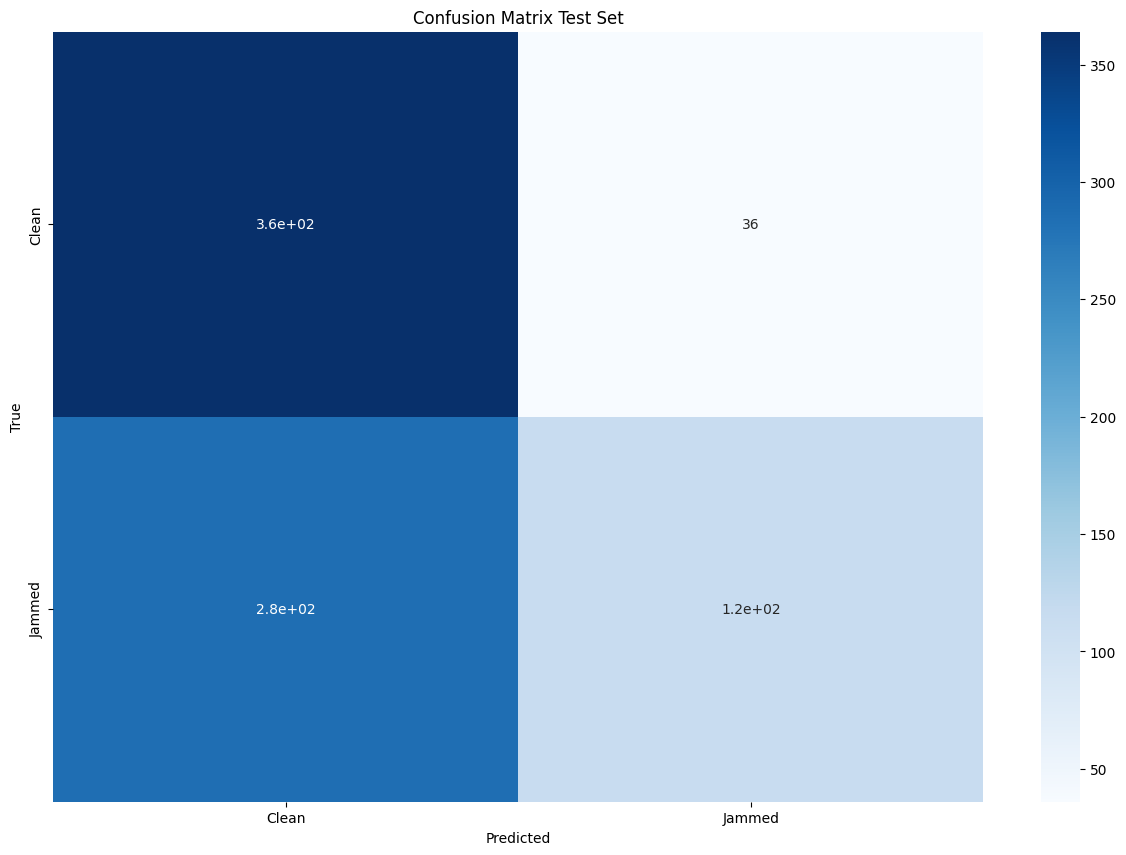

In [29]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold